# Generating skewed mrw

In this notebook, we analyzed the ability to generate skewed mrw, and anlyzing more specifically the capacity to generate the time non-reversibility, without modifying our models. 

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import os
import datetime
import numpy as np
from time import time, strftime
import pandas as pd
import statsmodels.api as sm

from plot_result import Analysis_sf, Analysis_m
from fbm import fbm
from mrw import mrw

from training import Trainer

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
latent_dim = 2**12
ts_dim = 2**12
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10000
n = 10
batch_size = 128

In [3]:
def complet_training(n, savepath, namepath, latent_dim, ts_dim, epochs, device):
    generators = []
    discriminators = []
    trainers = []
    synthetic_datas = []
    plot_result_sf = []
    plot_result_m = []
    
    # Create Scorepath
    scorepath = r'C:\Users\Stage\Desktop\smrw\Dense'
    
    # Init parameters
    lr_a = 1e-4
    lr_b = 1e-4
    
    # Exportation true data
    true_data = torch.tensor(pd.read_csv('data_train' + namepath).to_numpy().astype('float32')).to(device)
    
    for i in range (n):
        
        print('.....')
        print('New Training')
        print('.....')
        
        data_train = true_data[np.random.randint(low = 0, high = true_data.cpu().shape[0], size = 10000)]
        
        generator = Generator().to(device)
        discriminator = Discriminator(ts_dim = ts_dim).to(device)
        
        # Init optimizers
        G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
        D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

        # Training
        path = os.path.join(scorepath, 'Training n° ' + str(i+1)) 
        if not os.path.exists(path):
            os.makedirs(path)
        train = Trainer(generator, discriminator, G_opt, D_opt, batch_size, latent_dim, ts_dim, data_train, device, path)
        train.train(epochs=epochs)
        
        # Save models
        noise = torch.normal(mean = 0, std = 0.3, size = (10000, latent_dim)).to(device)
        synthetic_data = generator(noise).cpu()
        with torch.no_grad():
            x = synthetic_data[np.random.randint(low = 0, high = 10000)]
            plt.plot(x, linewidth = 0.5)
            plt.title('Sample of synthetic data GAN n°' + str(i+1))
            plt.show()
            sm.graphics.tsa.plot_acf(x.detach().numpy(), lags=100, zero = False)
            plt.show()
 
        plot_analysis_m = Analysis_m(data_train, synthetic_data, path)
        plot_analysis_sf = Analysis_sf(data_train, synthetic_data, path)
        plot_analysis_m.dataFrame()
        plot_analysis_m.boxplot()
        plot_analysis_sf.plot()
        df_data, df_synthetic = plot_analysis_sf.dataFrame()
        
        generators.append(generator.cpu())
        discriminators.append(discriminator.cpu())
        trainers.append(train)
        synthetic_datas.append(synthetic_data.cpu())
        plot_result_sf.append(plot_analysis_sf)
        plot_result_m.append(plot_analysis_m)
        
    return generators, discriminators, trainers, synthetic_datas, plot_result_sf, plot_result_m

In [4]:
from torch.nn.parameter import Parameter
class btanha(nn.Module):
    
    def __init__(self, alpha = None, beta = None, initialisation = 0.5):
        super(btanha,self).__init__()
        
        self.tanh = nn.Tanh()
        
        if alpha == None :
            self.alpha = Parameter(torch.tensor(initialisation))
        else :
            self.alpha = Parameter(torch.tensor(alpha))
        self.alpha.requiresGrad = True
        
        if beta == None :
            self.beta = Parameter(torch.tensor(initialisation))
        else :
            self.beta = Parameter(torch.tensor(alpha))
        self.beta.requiresGrad = True
        
    def forward(self,x): 
        return self.beta* self.tanh(self.alpha * x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.ts_dim = ts_dim
        self.conv1 = nn.Conv1d(1, 32, kernel_size = 7, padding = 'same')
        self.conv2 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same')
        self.conv3 = nn.Conv1d(32, 32, kernel_size = 7, padding = 'same') 
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear(self.ts_dim*8, 50) 
        self.dense2 = nn.Linear(50, 15)
        self.dense3 = nn.Linear(15, 1)    
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.max_pool1d(x, 2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.max_pool1d(x,1)
        x = self.flatten(x)
        x = F.leaky_relu(self.dense1(x), 0.2)
        x = F.leaky_relu(self.dense2(x), 0.2)
        return F.leaky_relu(self.dense3(x), 0.2)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.Layer0 = nn.Linear(2**12,2**12)
        self.batch0 = nn.BatchNorm1d(1)
        
        self.conv1 = nn.ConvTranspose1d(8, 4, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch1 = nn.BatchNorm1d(4)
        self.conv2 = nn.ConvTranspose1d(4, 2, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch2 = nn.BatchNorm1d(2)
        self.conv3 = nn.ConvTranspose1d(2, 1, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch3 = nn.BatchNorm1d(1)
        self.f = btanha()


    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        x = self.Layer0(x)
        x = self.batch0(x)
        x = F.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], 8, x.shape[2]//8)

        x = self.batch1(self.conv1(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch2(self.conv2(x))
        x = F.leaky_relu(x, 0.2)
        x = self.batch3(self.conv3(x))
        x = x.squeeze()
        return self.f(x)

.....
New Training
.....


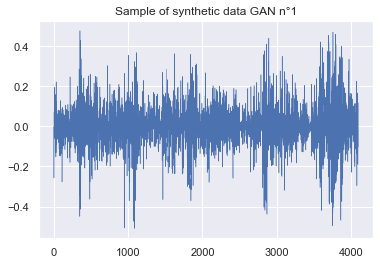

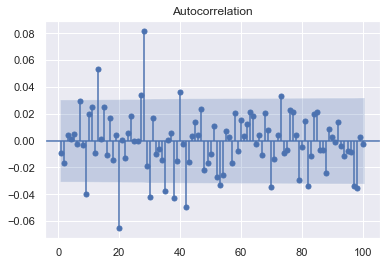

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

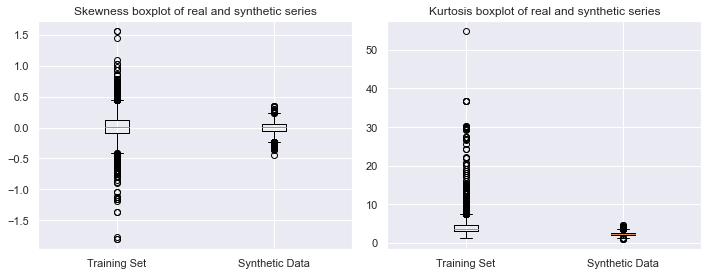

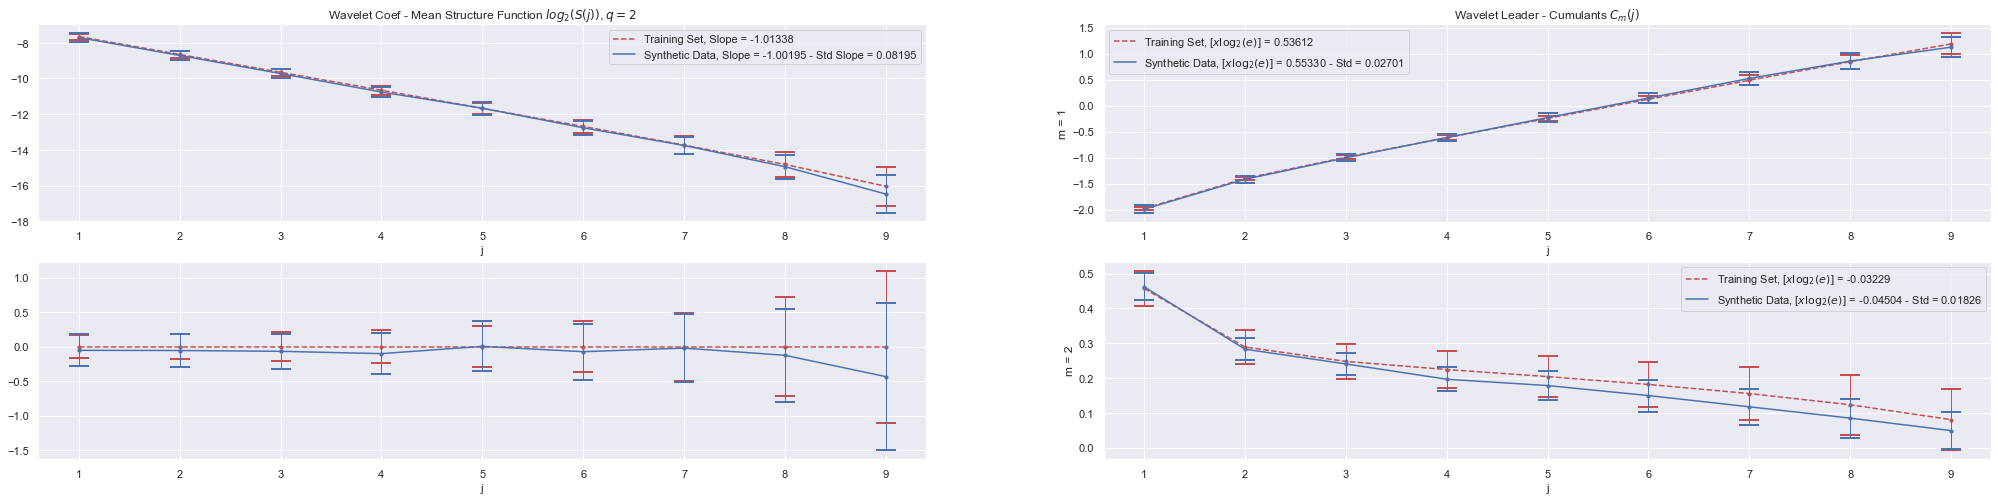

.....
New Training
.....


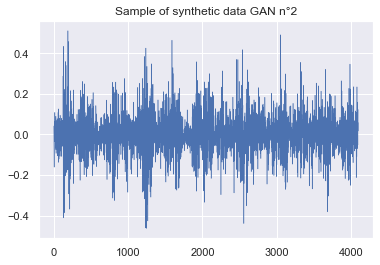

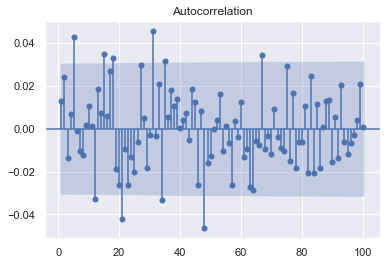

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

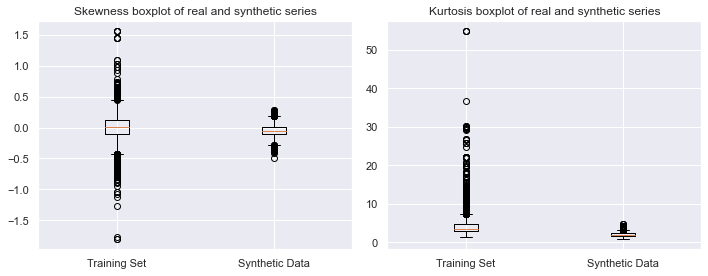

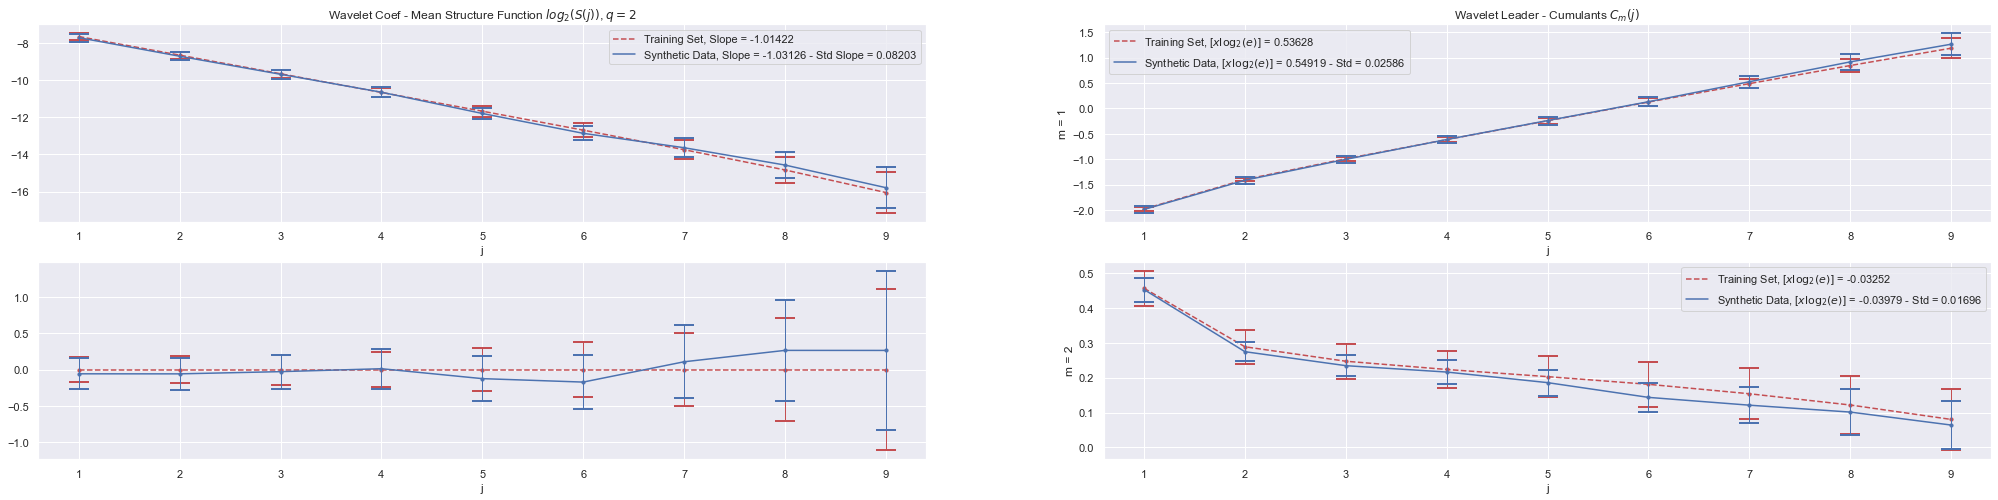

.....
New Training
.....


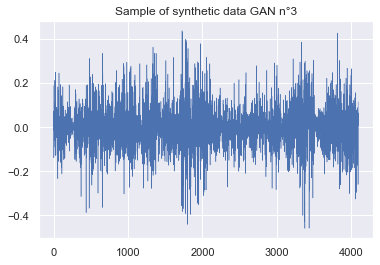

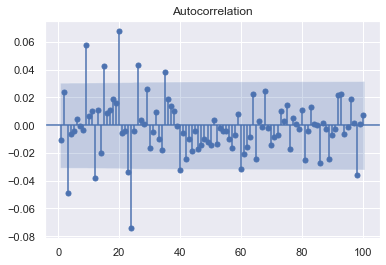

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

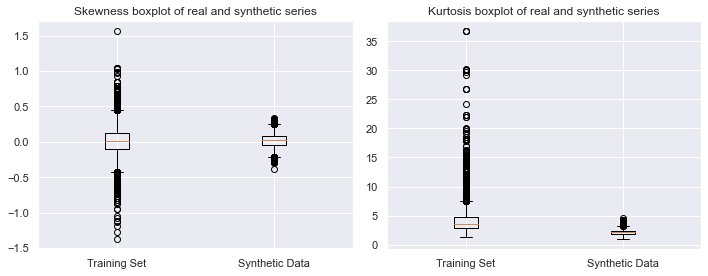

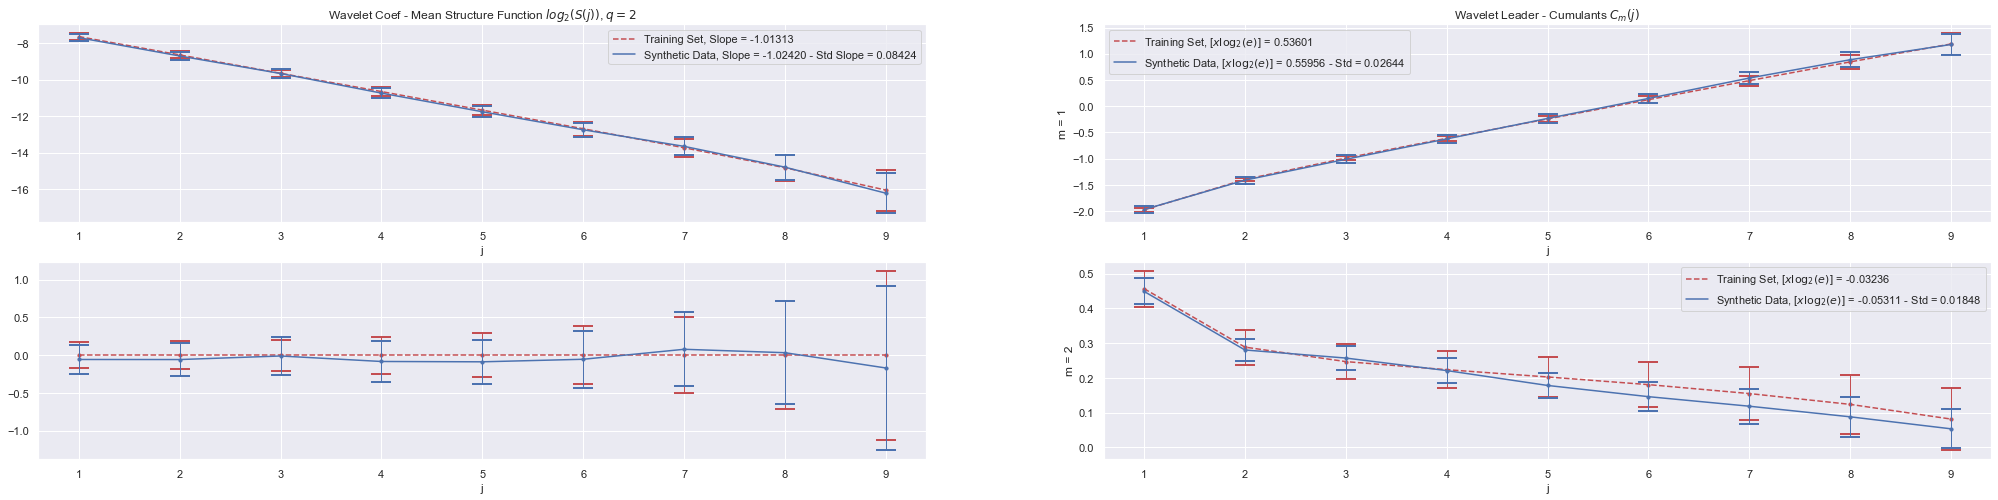

.....
New Training
.....


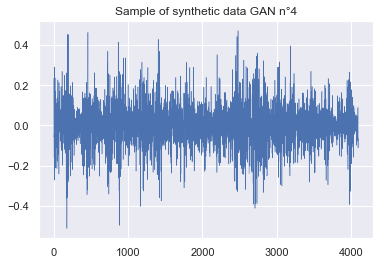

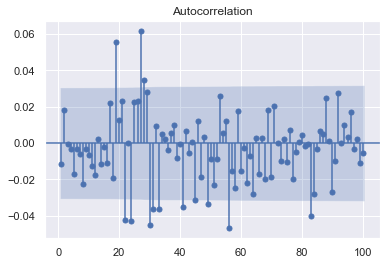

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

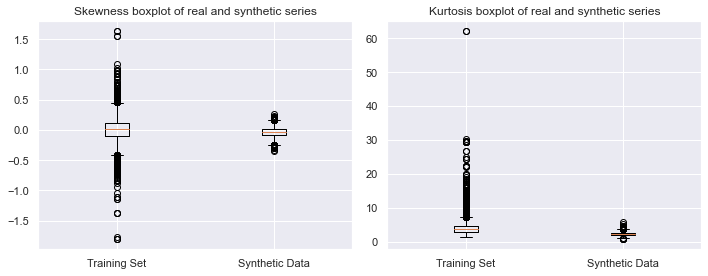

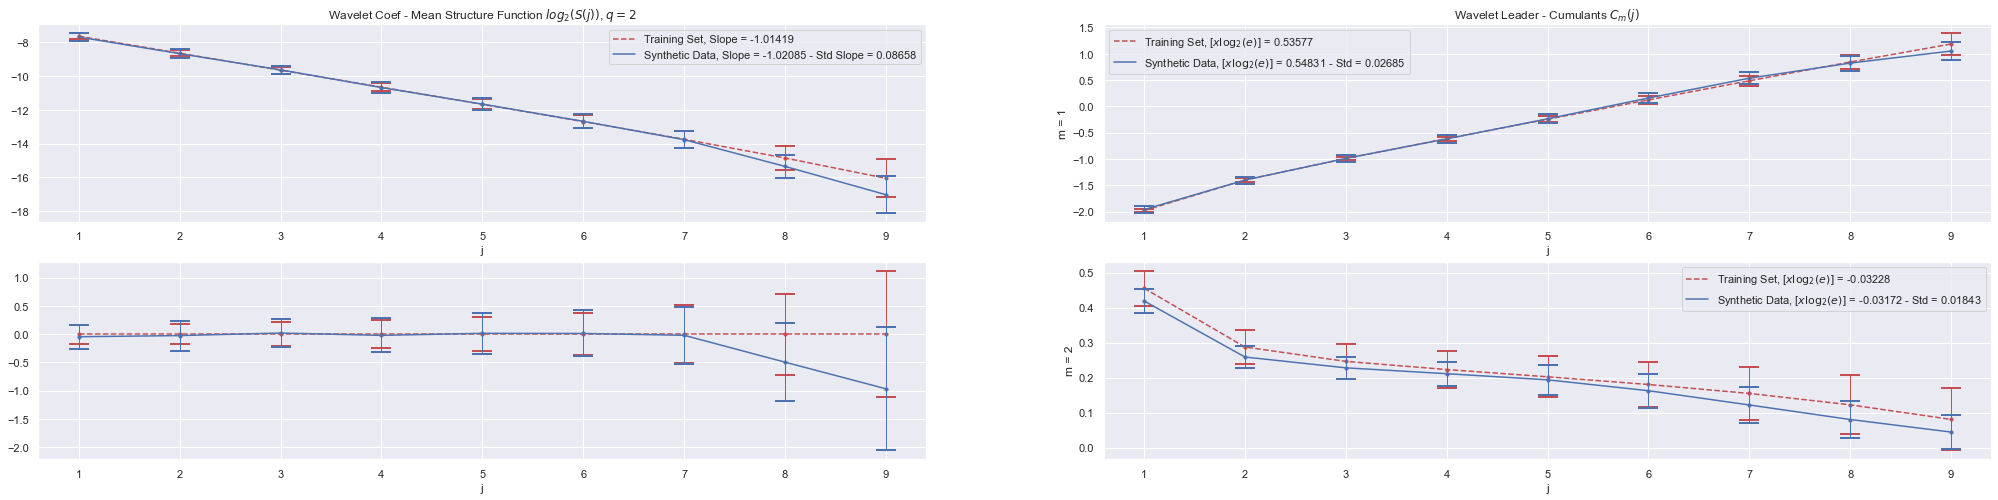

.....
New Training
.....


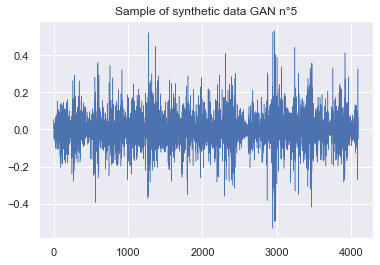

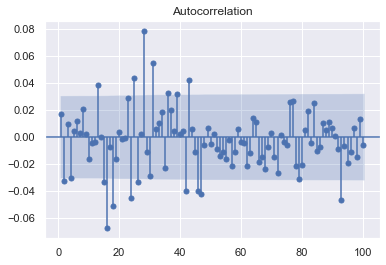

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

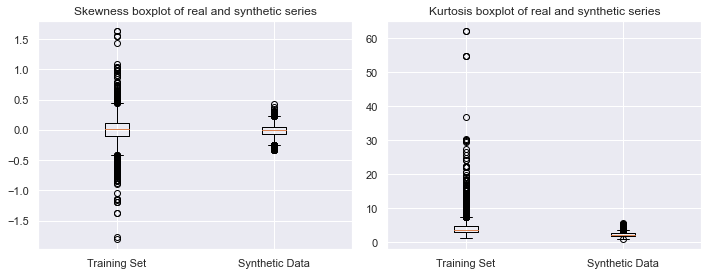

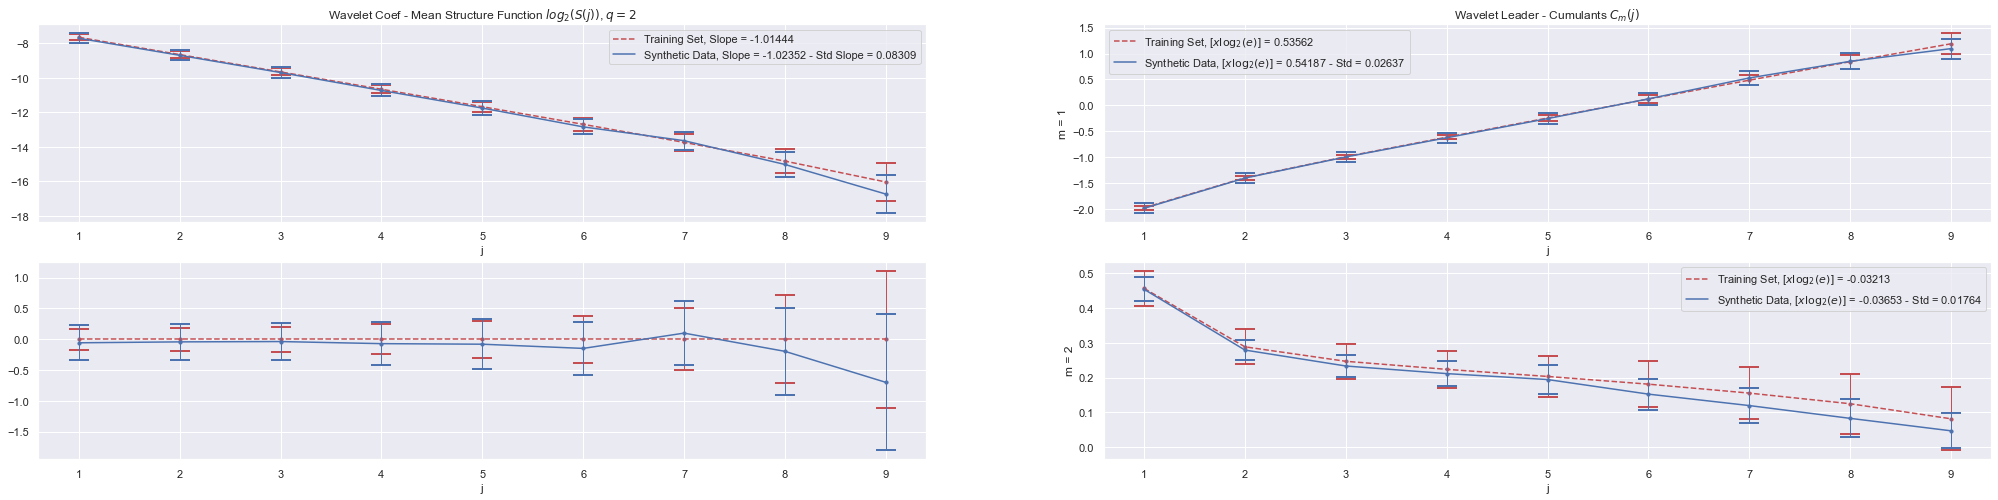

.....
New Training
.....


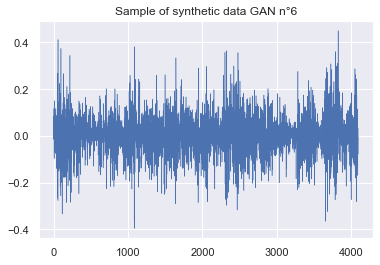

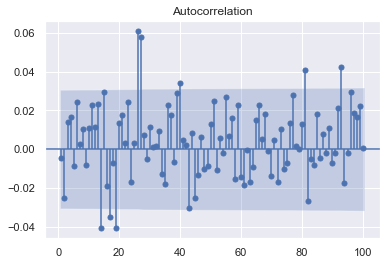

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

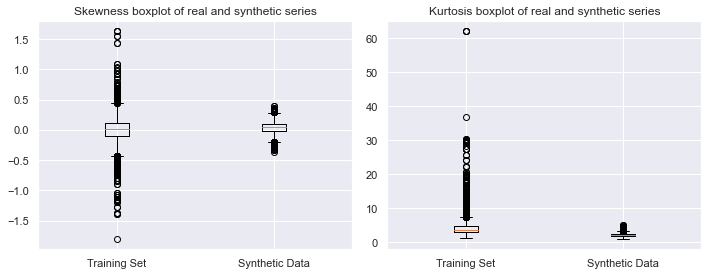

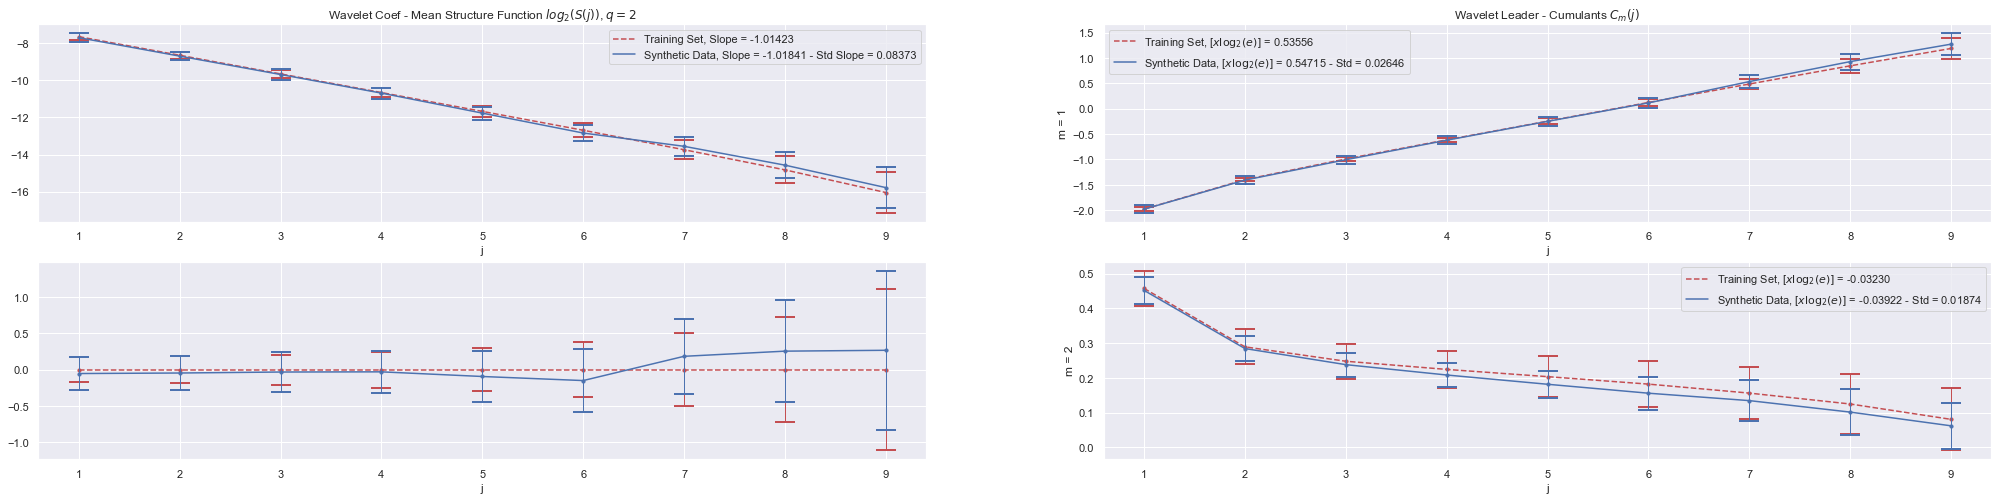

.....
New Training
.....


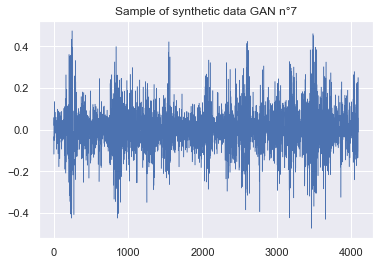

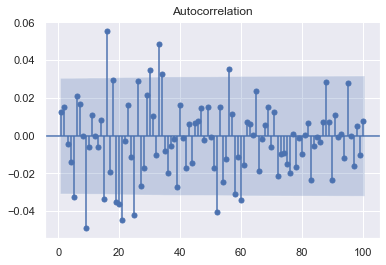

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

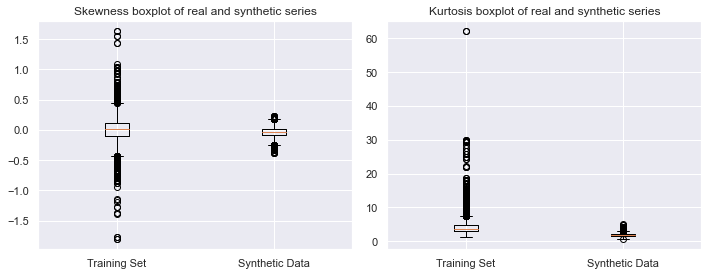

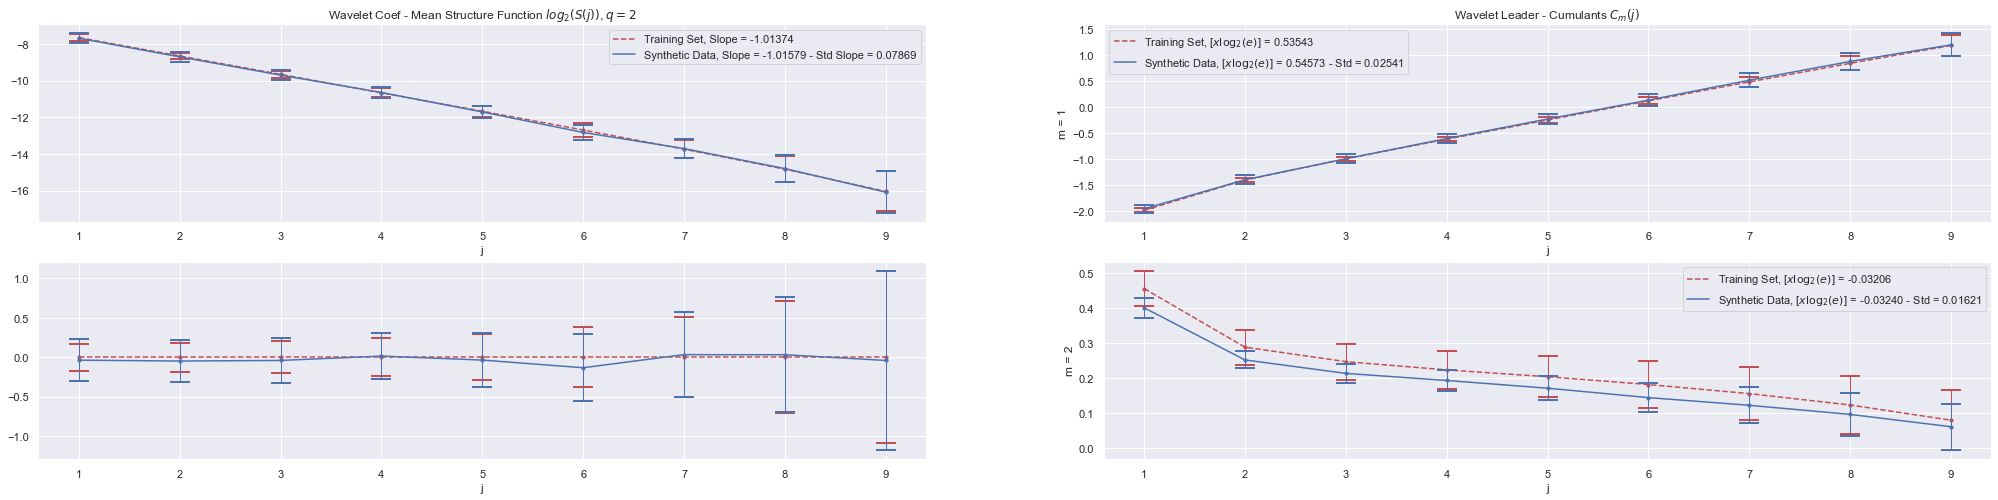

.....
New Training
.....


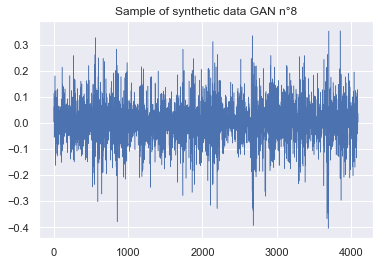

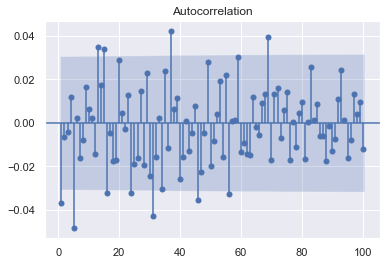

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

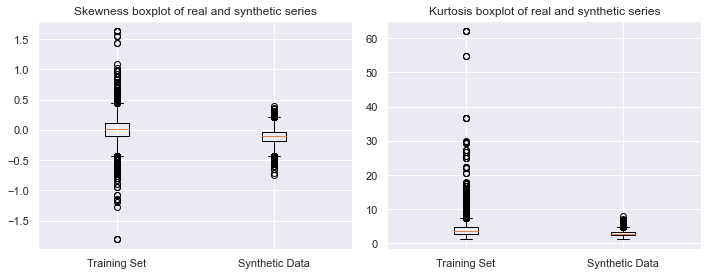

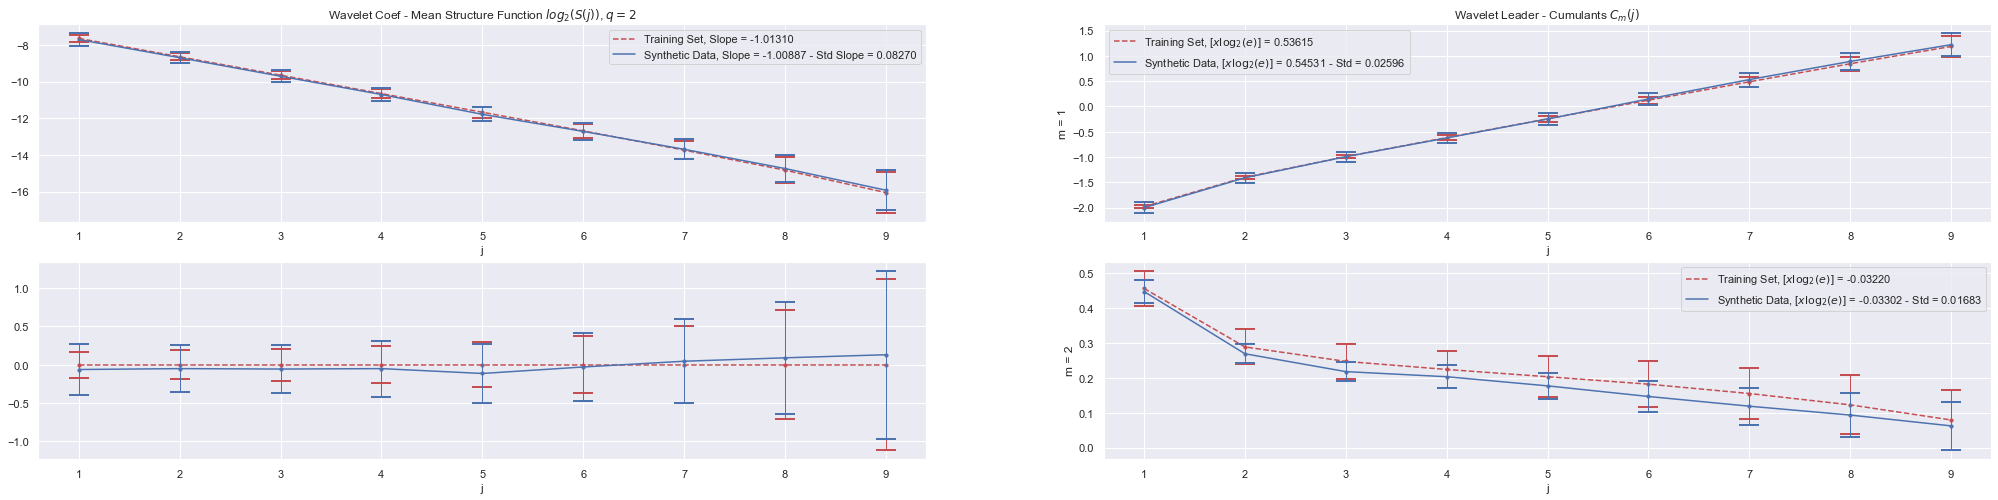

.....
New Training
.....


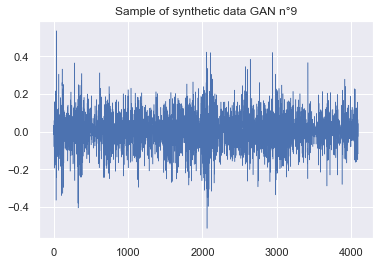

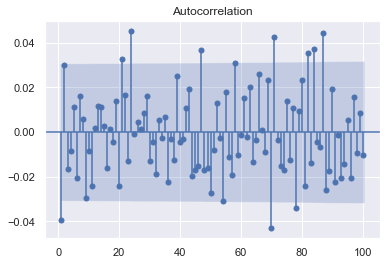

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

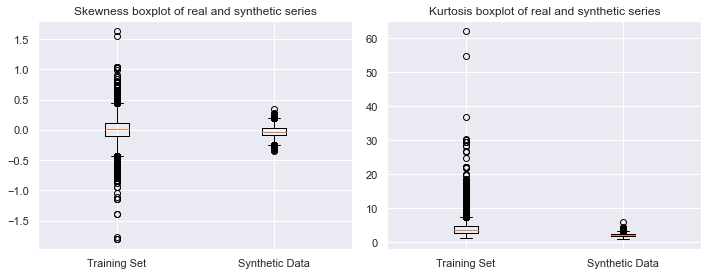

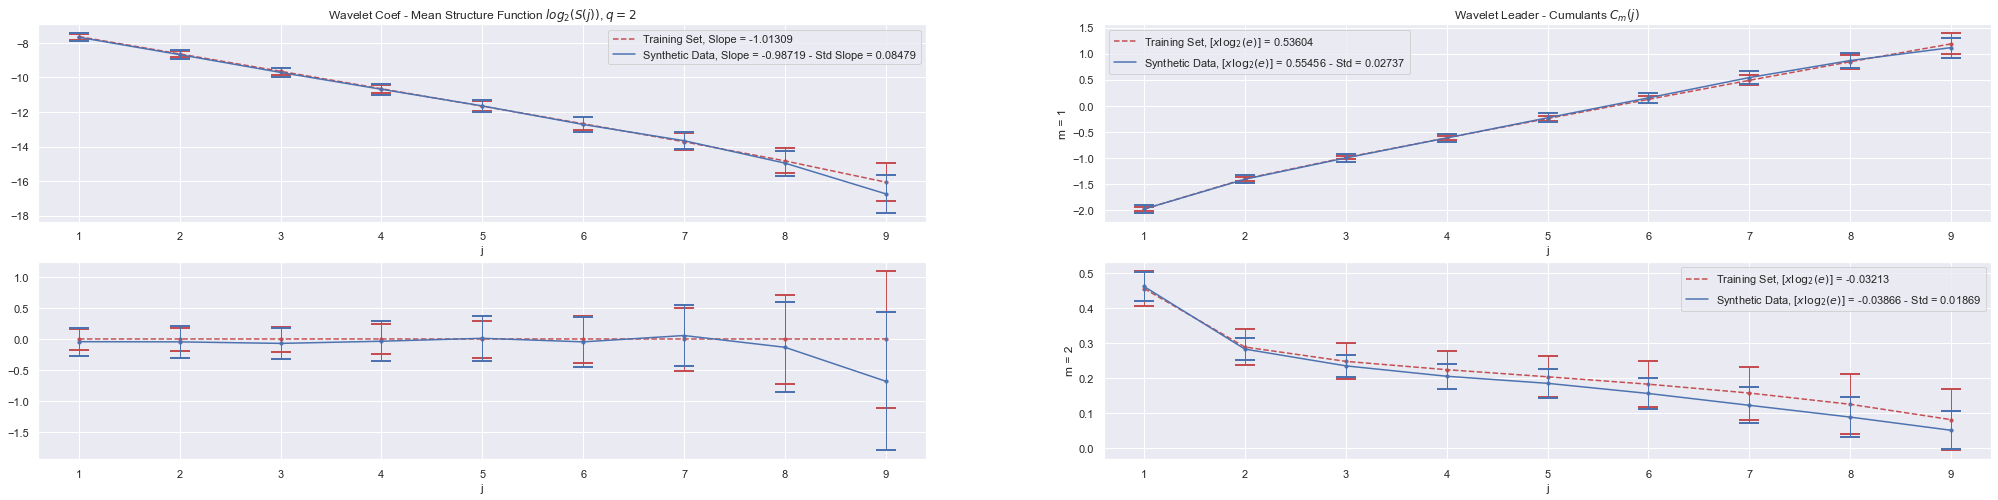

.....
New Training
.....


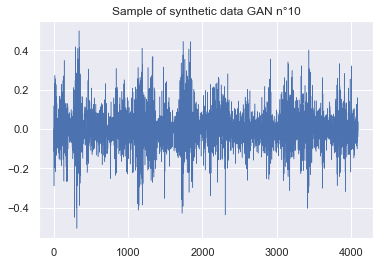

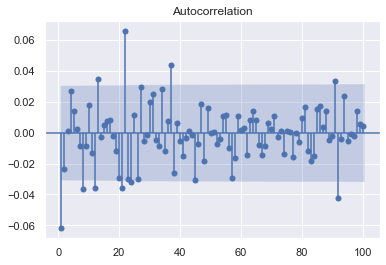

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")
C:\Us

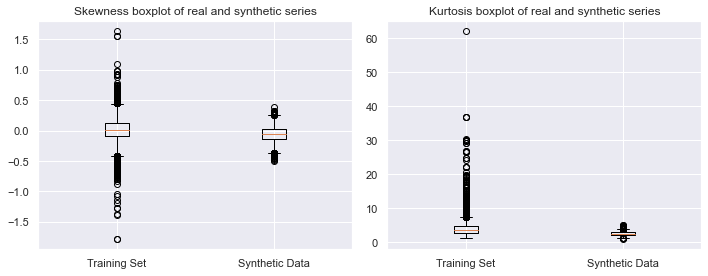

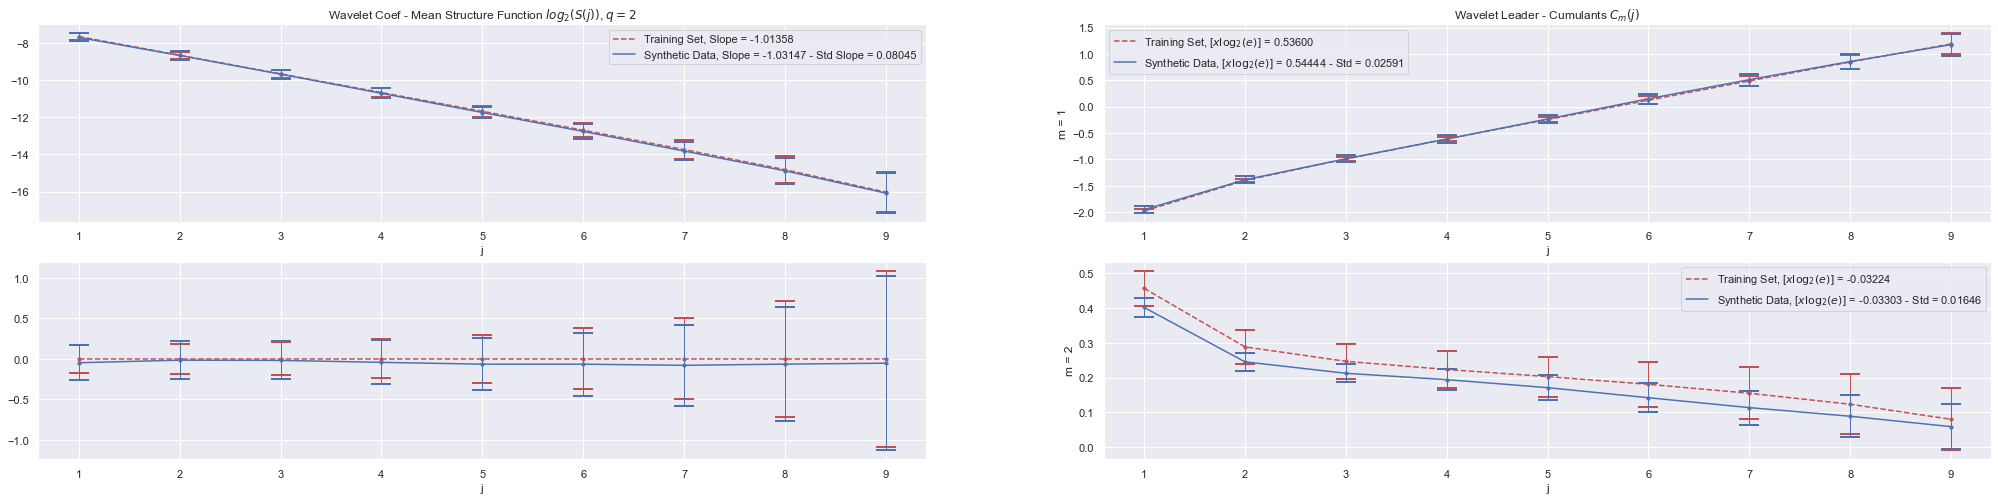

In [7]:
generatorsskew, discriminatorsskew, trainersskew, synthetic_datasskew, plot_result_sfskew, plot_result_mskew = complet_training(n, '2022-07-27_smrw', '\\training_set_smrw_0.8_0.03_0.1_0.8.csv', latent_dim, ts_dim, epochs, device)
torch.cuda.empty_cache()

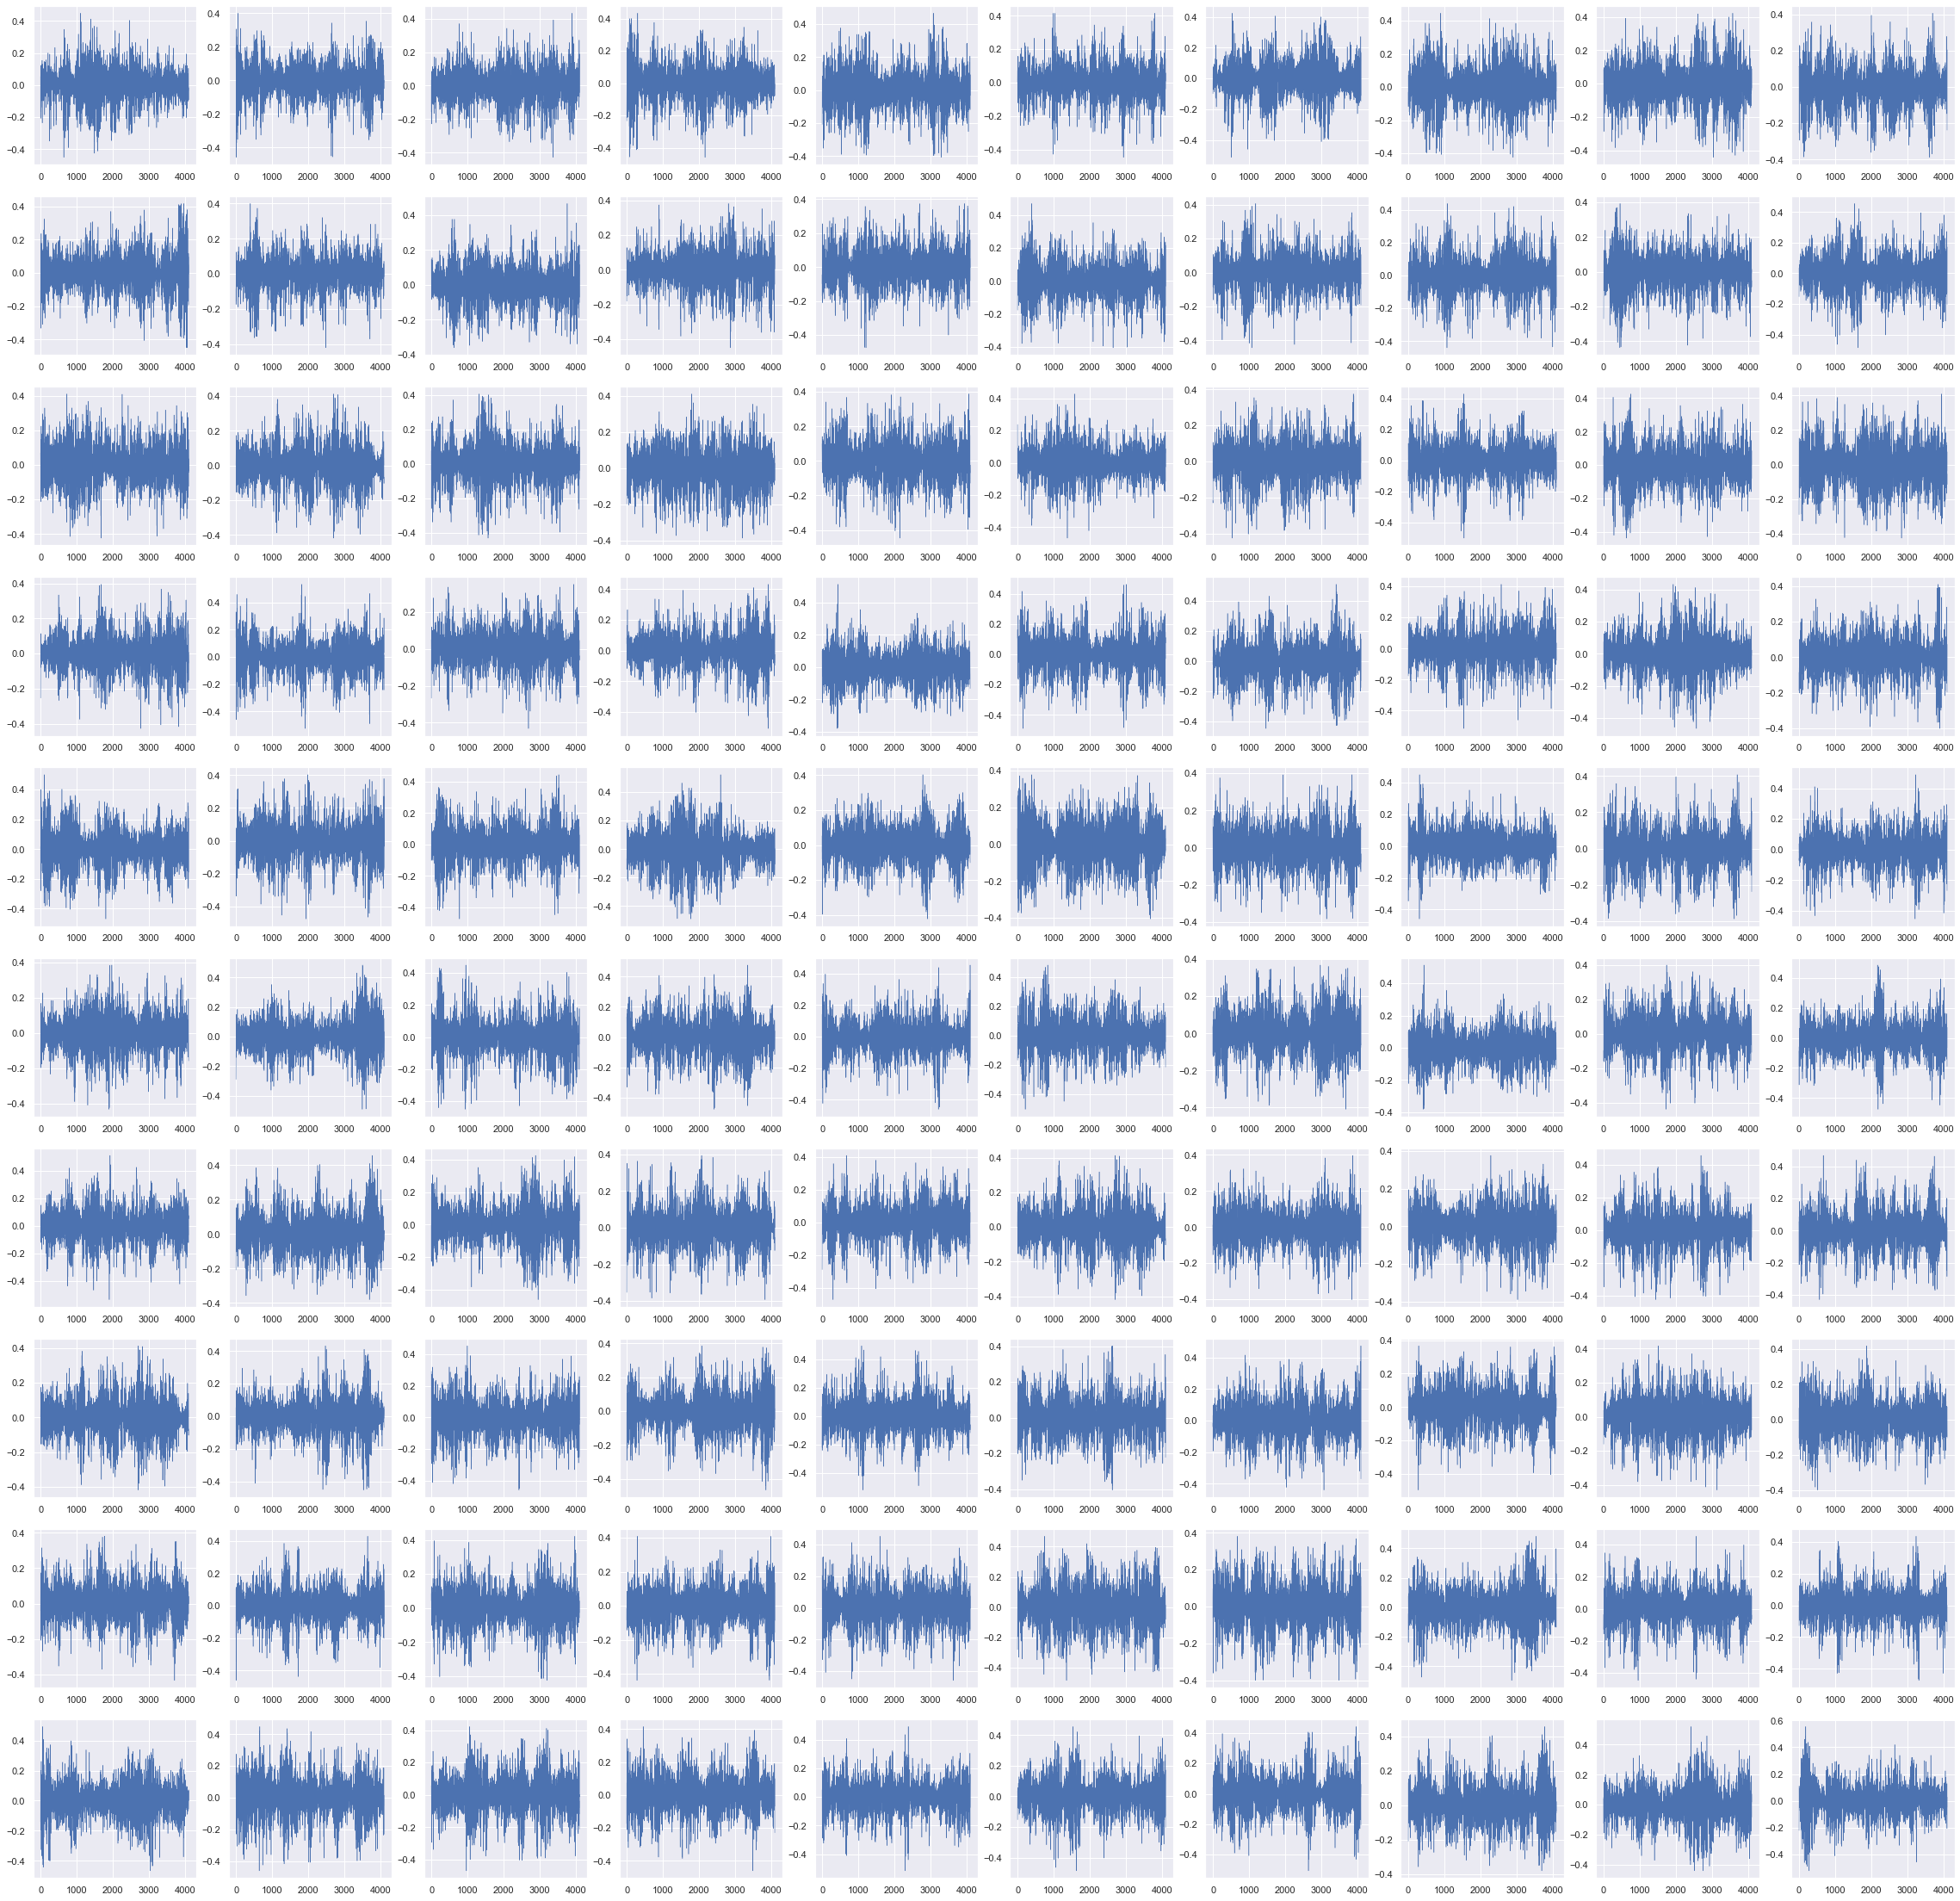

In [34]:
plt.figure(1, figsize =(40,40))
with torch.no_grad():
    for i in range (100):
        plt.subplot(10,10,i+1)
        plt.plot(synthetic_datasskew[0][np.random.randint(low = 0, high = 1000)].cpu(), linewidth = 0.5)

In [5]:
synthetic_datasskew =[]
for i in range (1,4):
    generator = Generator()
    generator.load_state_dict(torch.load( r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-07-27_smrw\Training n° {}\10000\generator10000 epochs.pth'.format(i)))
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**12))
    synthetic_data = generator(noise)
    synthetic_datasskew.append(synthetic_data)

C:\Users\Stage\anaconda3\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


In [6]:
# Estimate leverage effect
def leverage(r):
    R, N = r.shape
    #dr = np.diff(r, axis=1)
    r2 = r ** 2
    L = np.stack([np.correlate(r2[k], r[k], mode='full') / N
                                                                        for k in range(R)], axis=0)
    L = np.mean(L, axis=0) / (np.mean(r2))
    tau = np.arange(-N+1, N)
    return L, tau

In [25]:
from scipy import io as spio
from matplotlib import pyplot as plt
from mrw import skewed_mrw
import time
import numpy as np

N = 2**12             # Number of samples
R = 100             # Number of realizations
H = 0.5               # Hurst parameter
lam = np.sqrt(0.03)   # Intermittency parameter
T = N                 # Integral scale
K0 = 0.1              # Kernel amplitude
alpha = 0.8           # Kernel exponent

x = skewed_mrw((N, R), H, lam, N, K0, alpha)
s=[]
for i in range (R):
    std = x[:,i].std()
    s.append(std)

x = x / np.mean(s).mean() * 0.1

s=[]
for i in range (R):
    std = x[:,i].std()
    s.append(std)



y = np.array([x[:,i] for i in range(R)])

In [8]:
lev,tau = leverage(y)

In [9]:
lev_syn1, tau_syn1 = leverage(synthetic_datasskew[0].detach().numpy())
lev_syn2, tau_syn2 = leverage(synthetic_datasskew[1].detach().numpy())
lev_syn3, tau_syn3 = leverage(synthetic_datasskew[2].detach().numpy())

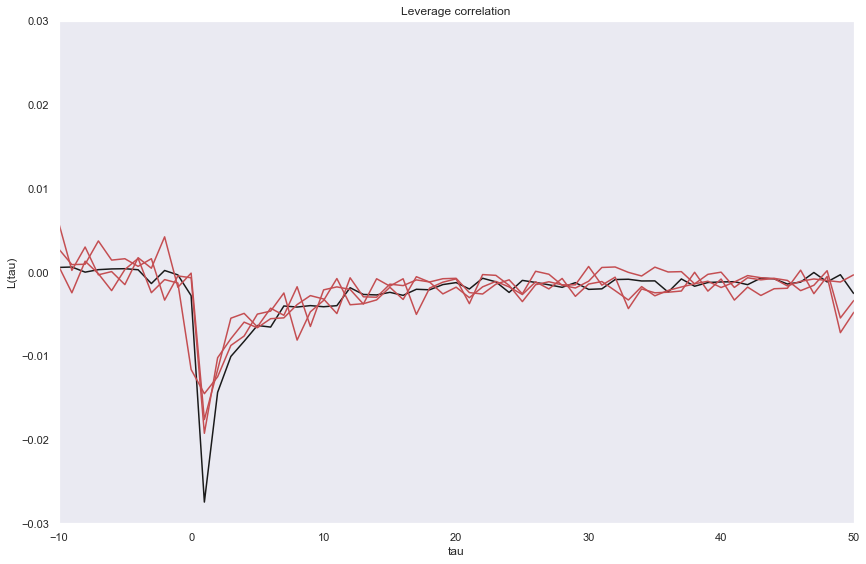

In [18]:
import seaborn as sns
sns.set(style="darkgrid")
plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(tau, lev, c = 'k')
plt.plot(tau_syn1, lev_syn1, c = 'r')
plt.plot(tau_syn2, lev_syn2, c ='r')
plt.plot(tau_syn3, lev_syn3, c ='r')
plt.xlim(-10, 50)
plt.ylim(-0.03,0.03)
plt.grid()
plt.xlabel('tau')
plt.ylabel('L(tau)')
plt.title('Leverage correlation')
plt.tight_layout()
plt.show()

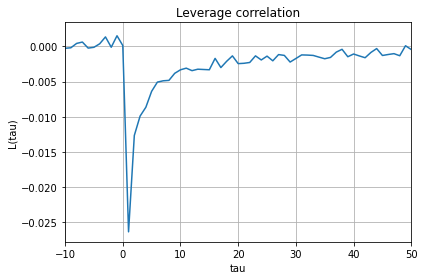

In [23]:
plt.plot(tau, lev)
plt.xlim(-10, 50)
plt.grid()
plt.xlabel('tau')
plt.ylabel('L(tau)')
plt.title('Leverage correlation')
plt.tight_layout()
plt.show()

In [22]:
data_train = pd.read_csv(r'data_train\training_set_smrw_0.8_0.03_0.05_0.1.csv').to_numpy().astype('float32')

In [23]:
lev_data,tau_data = leverage(data_train)

In [24]:
def leverage(r):
    R, N = r.shape
    dr = np.diff(r, axis=1)
    dr2 = dr ** 2
    L = np.stack([np.correlate(dr[k]**2, dr[k], mode='full') / N
                                                                        for k in range(R)], axis=0)
    L = np.mean(L, axis=0) / (np.mean(dr2))
    tau = np.arange(-N+2, N-1)
    return L, tau


lev,tau = leverage(synthetic_data.detach().numpy())

.....
New Training
.....


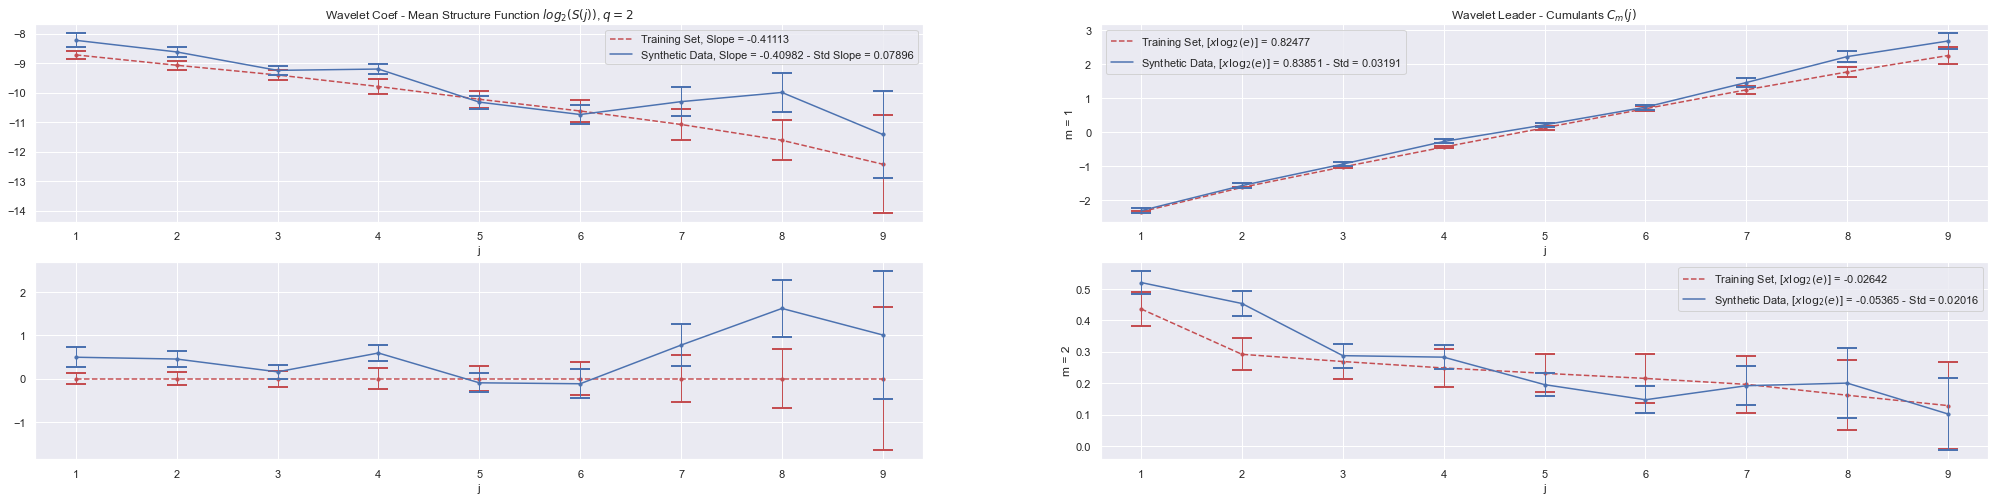

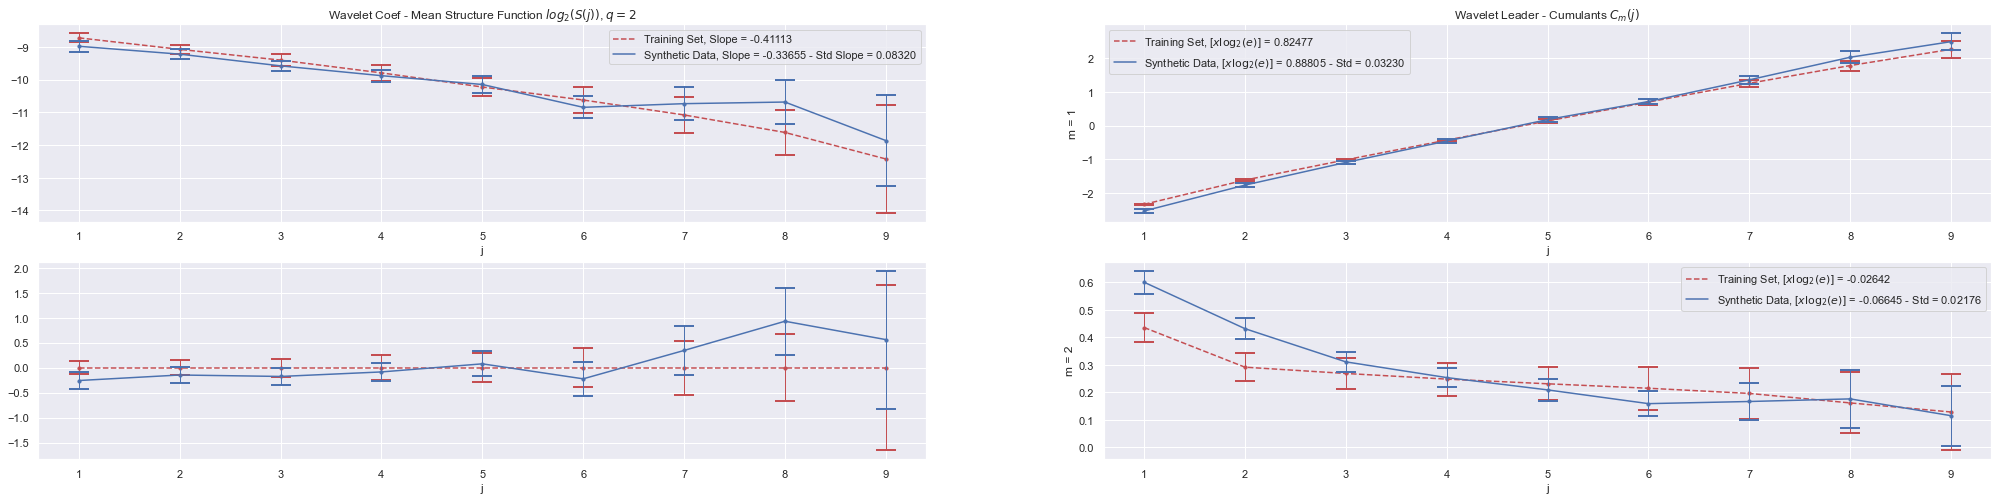

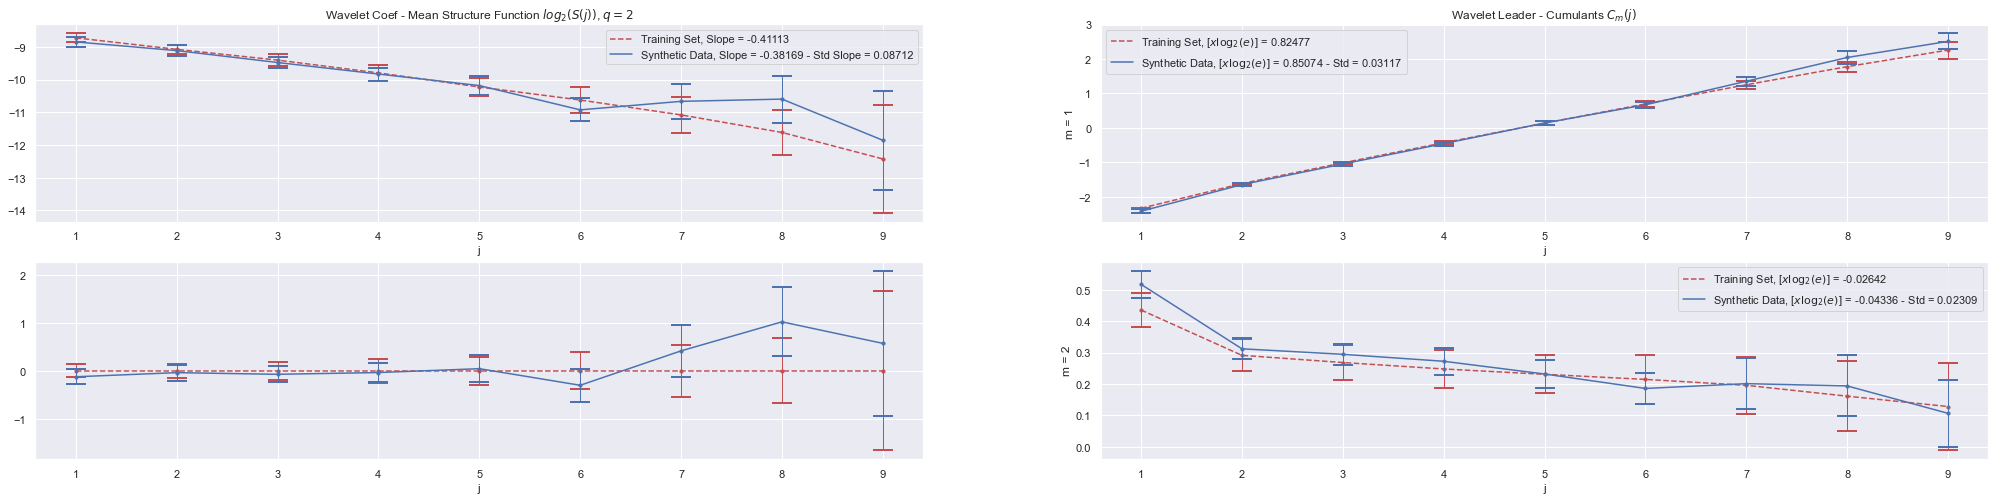

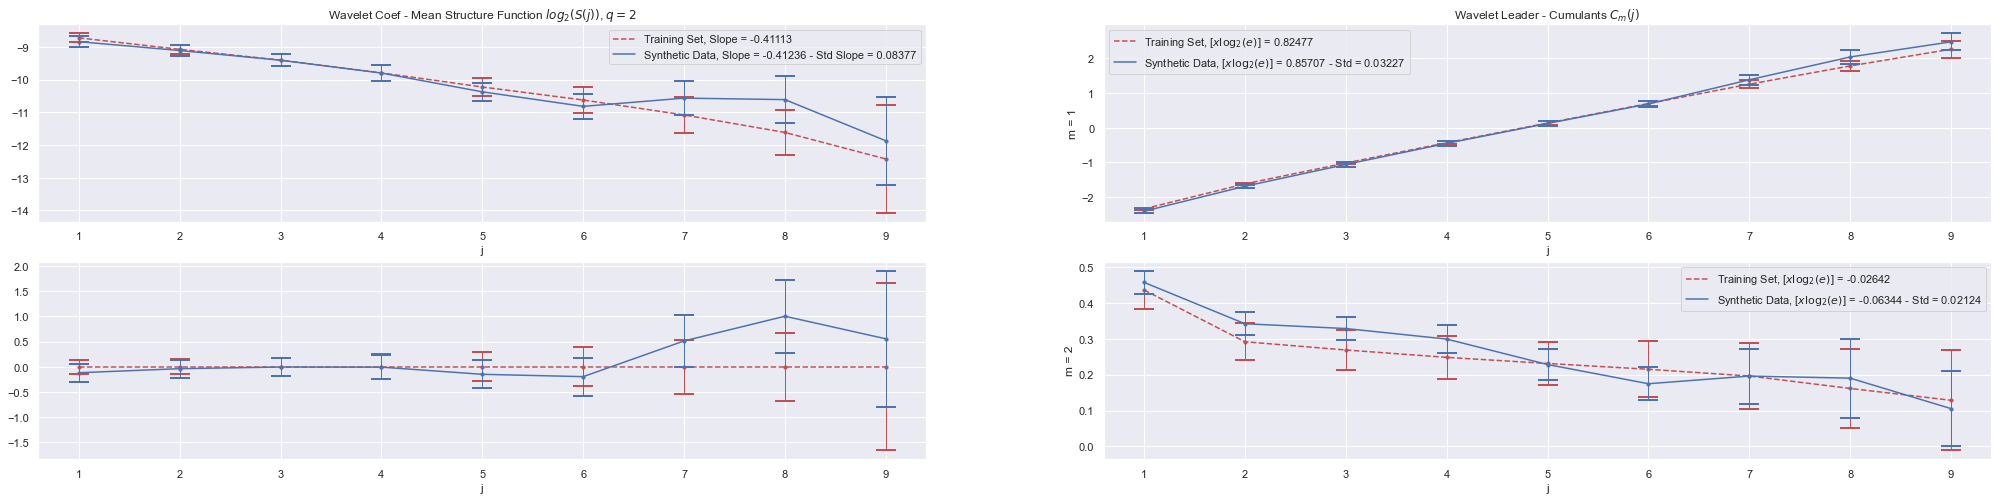

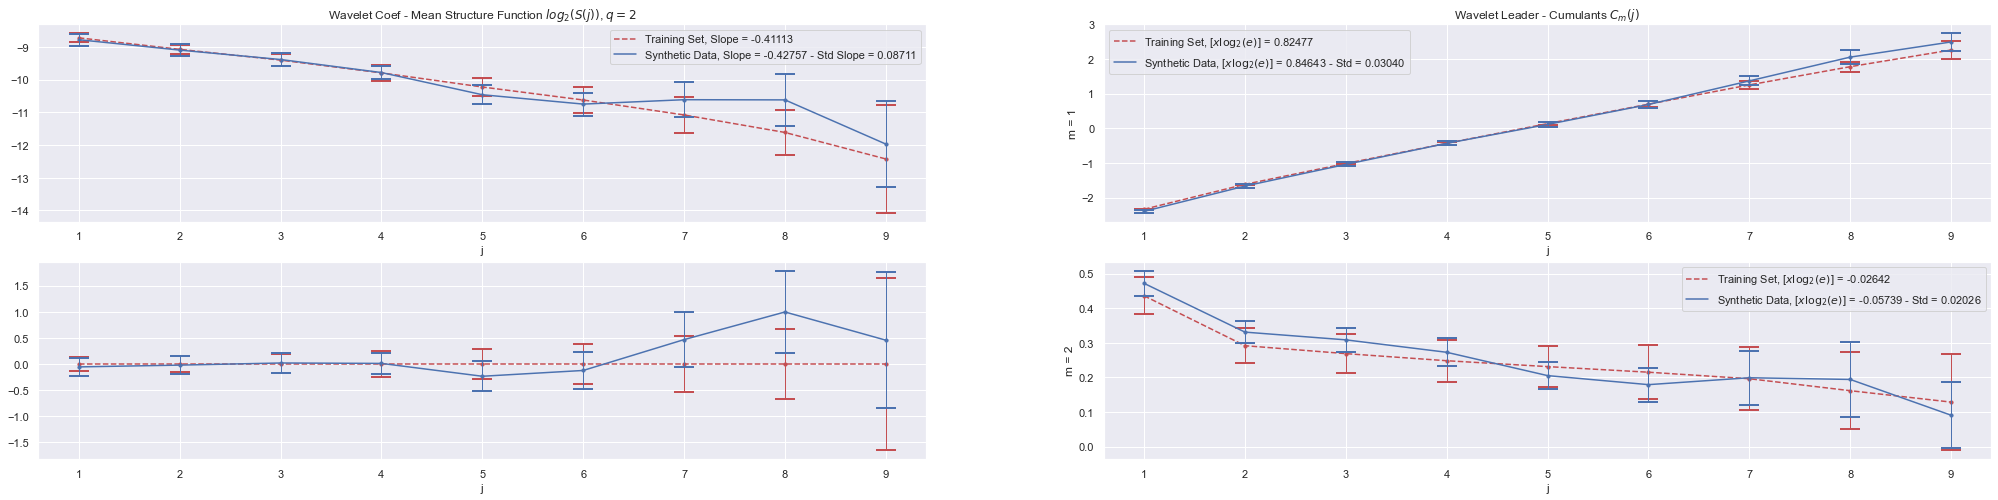

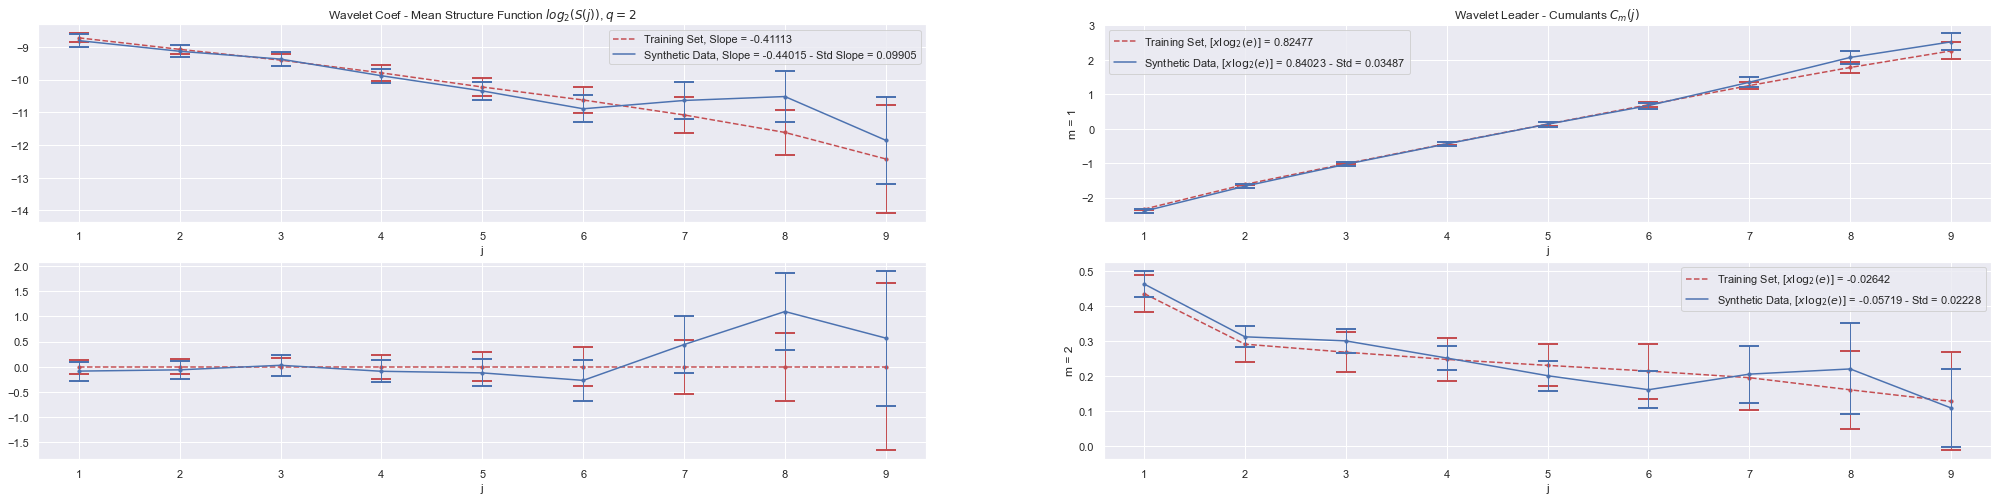

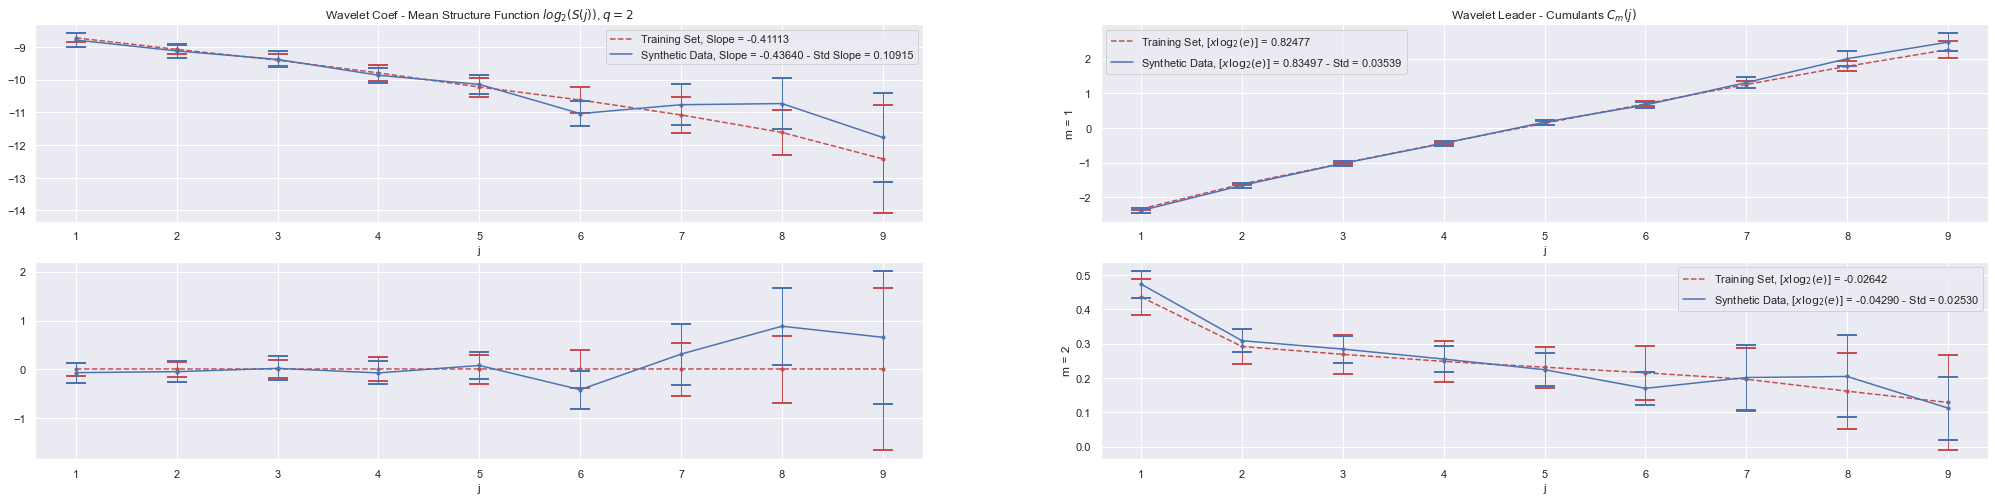

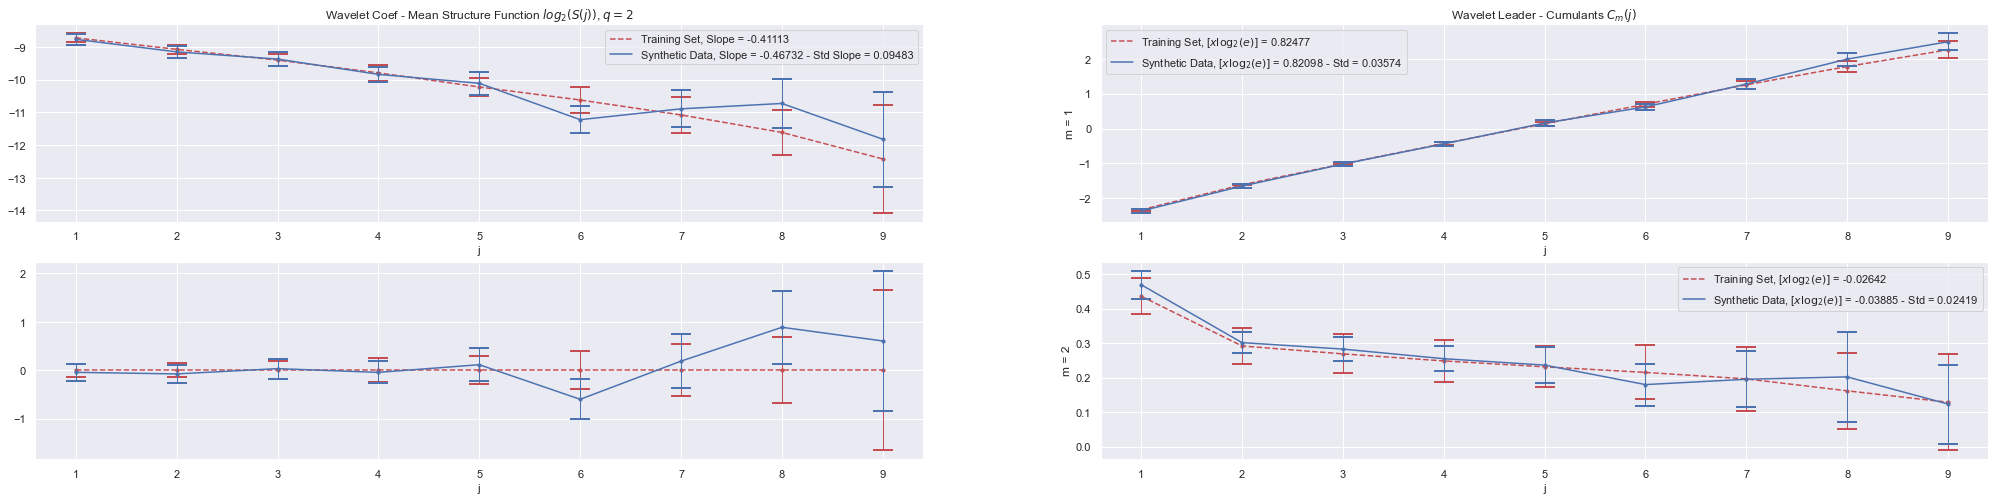

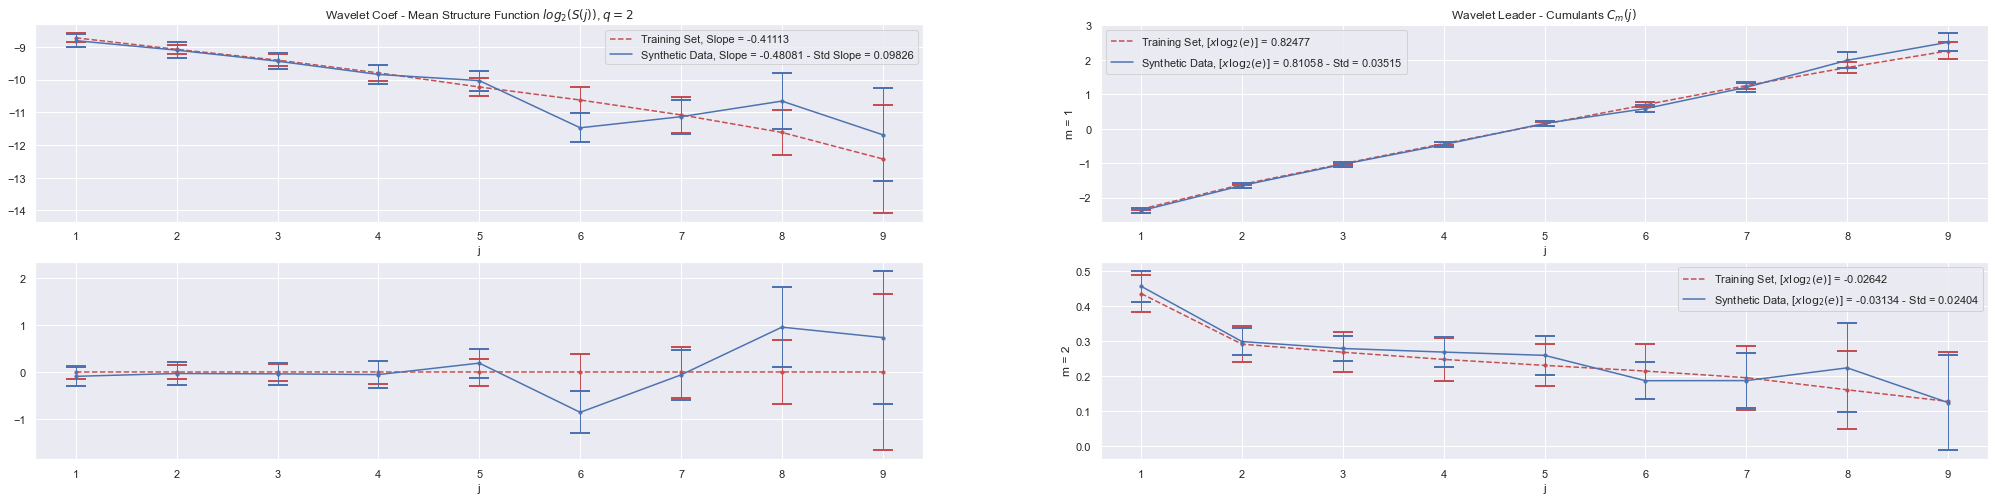

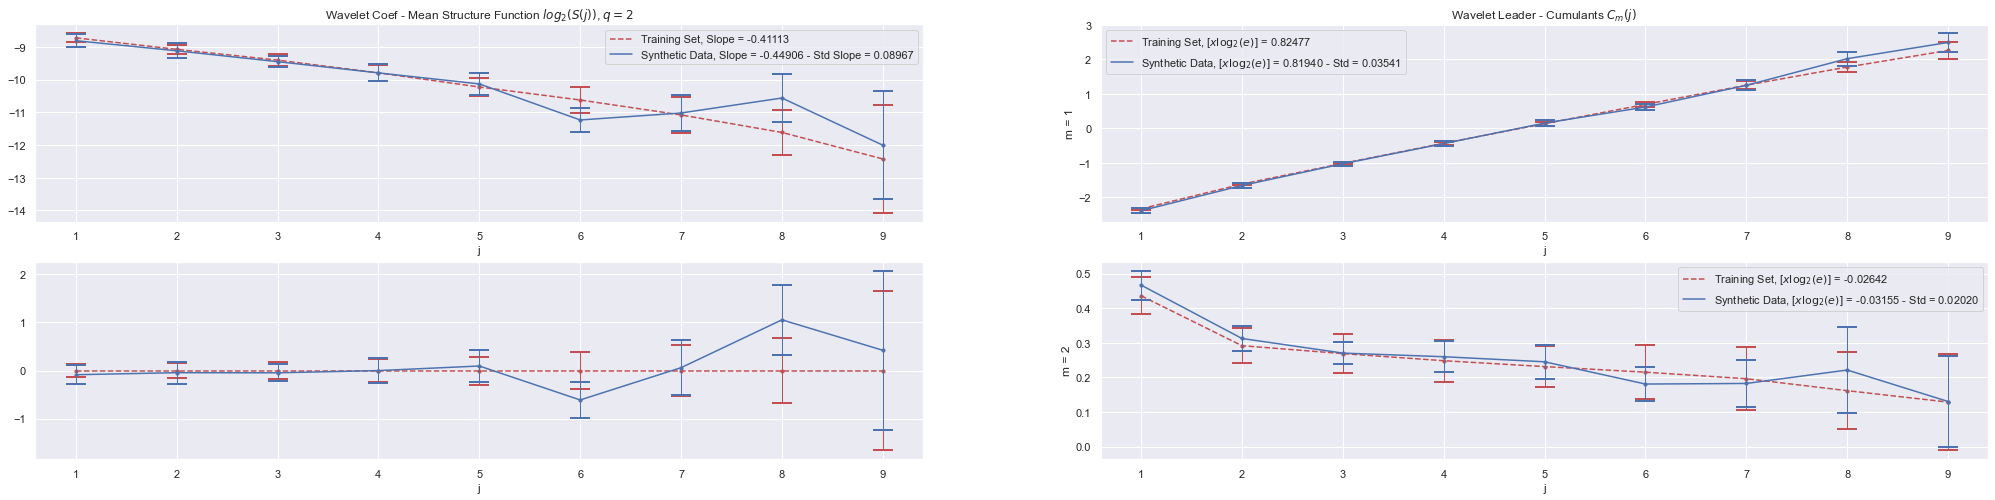

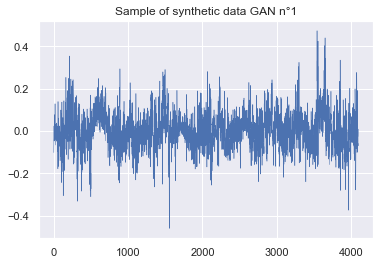

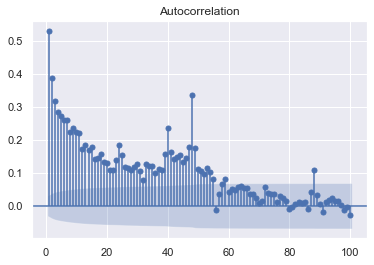

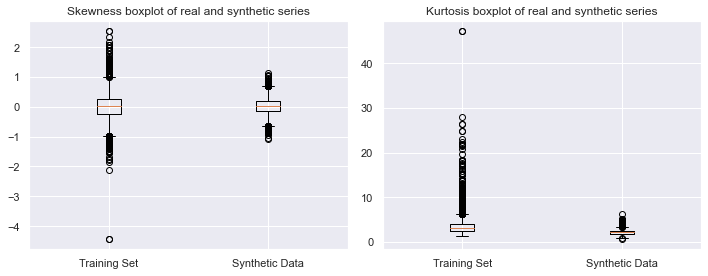

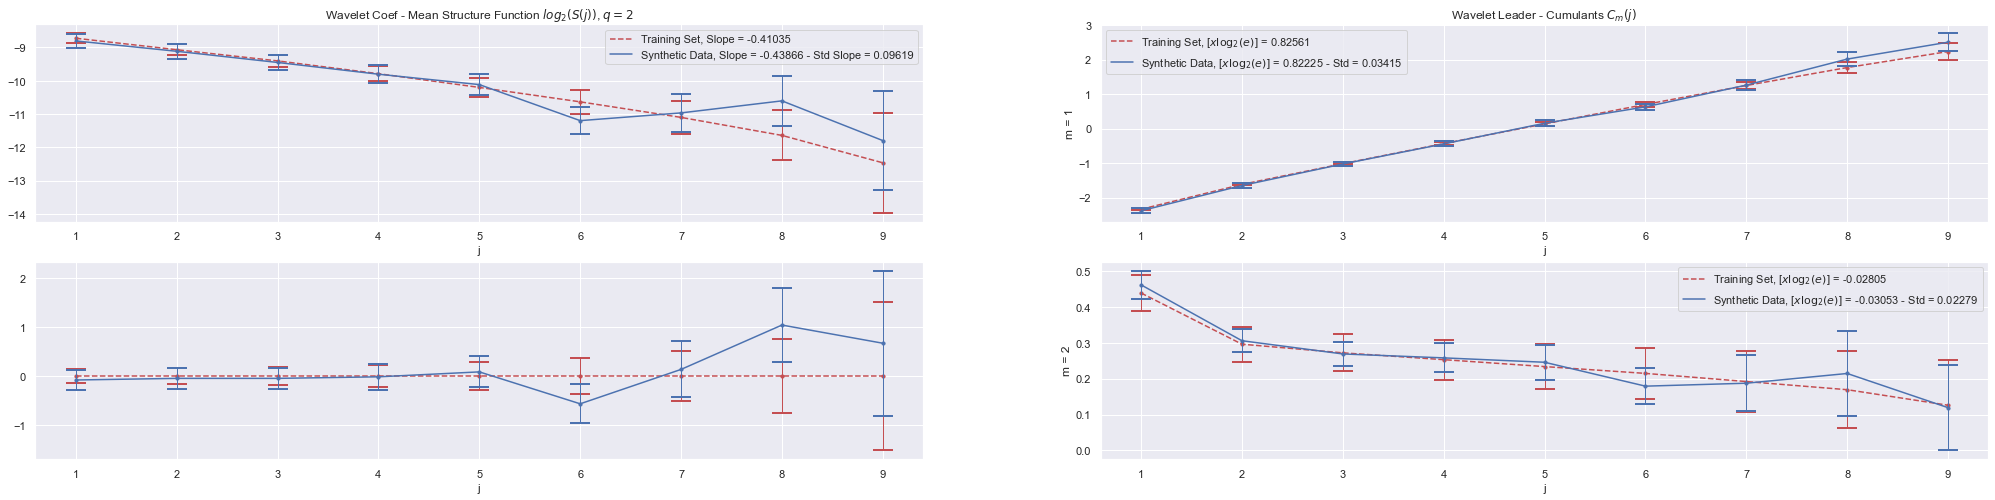

.....
New Training
.....


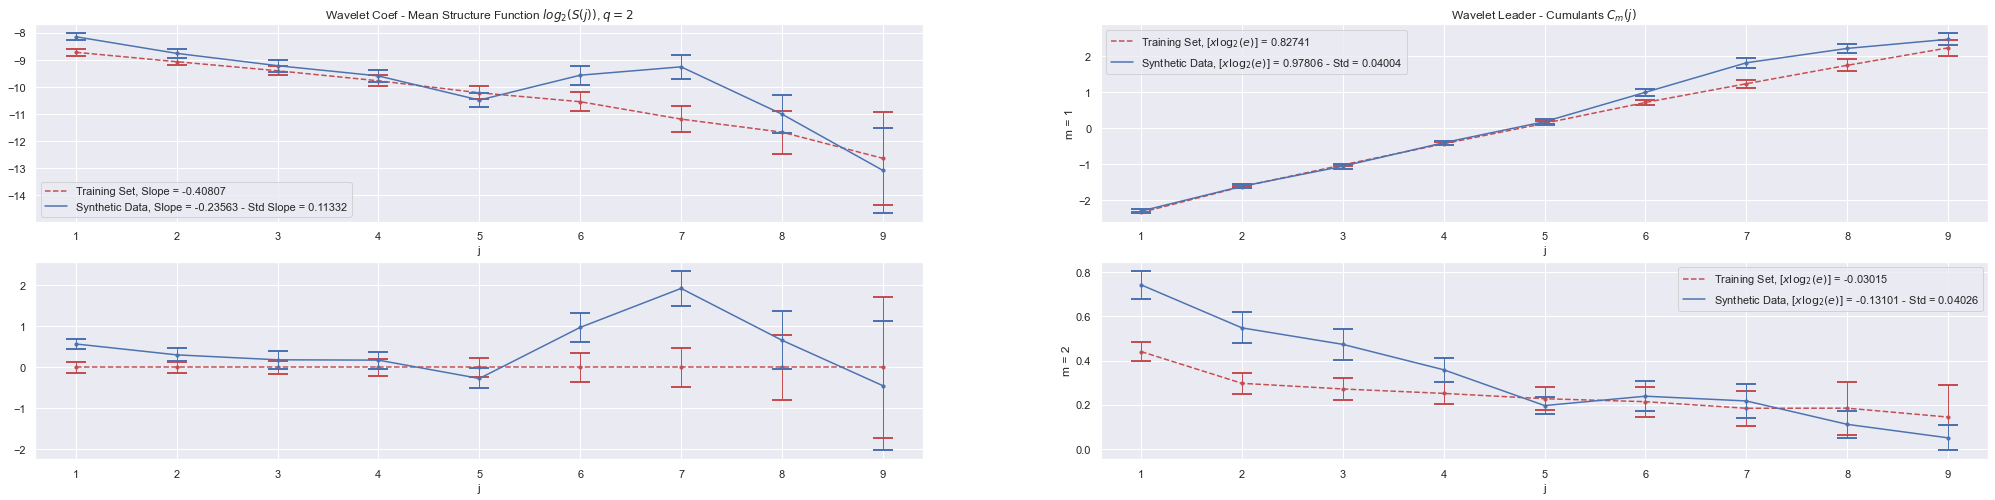

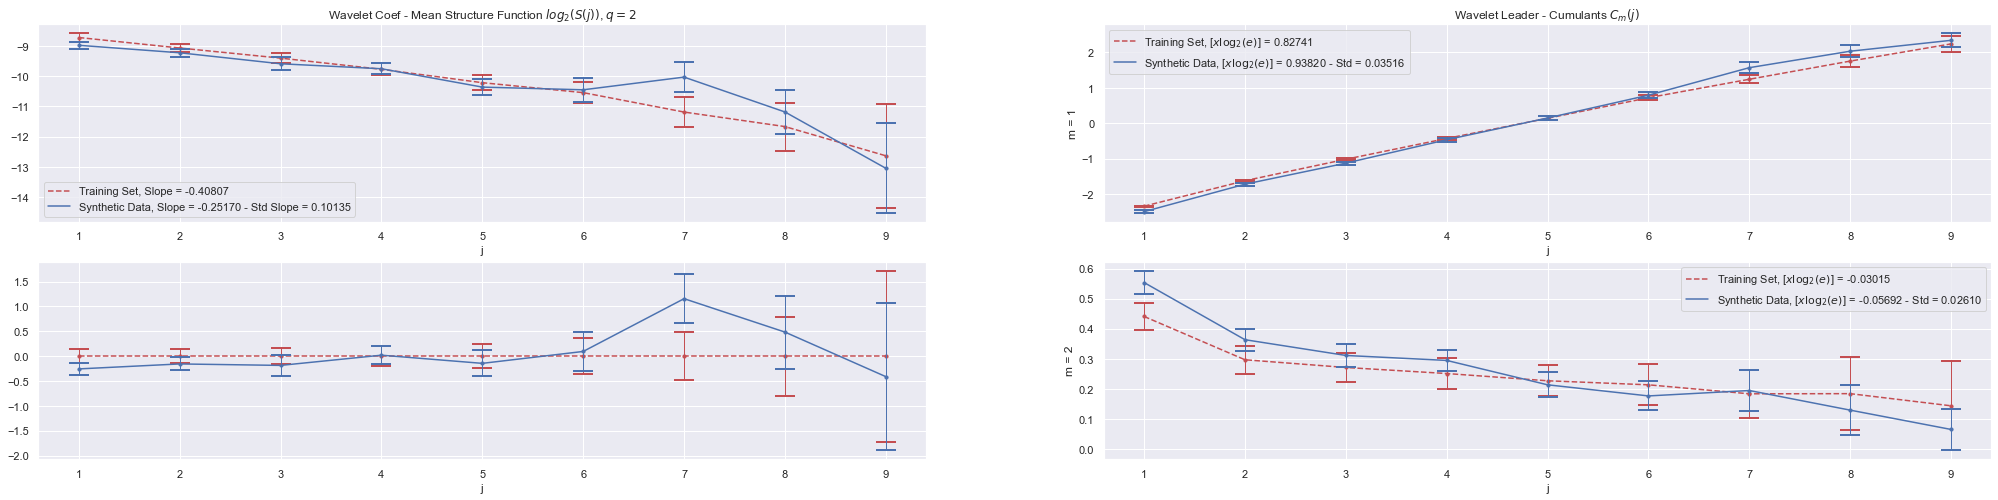

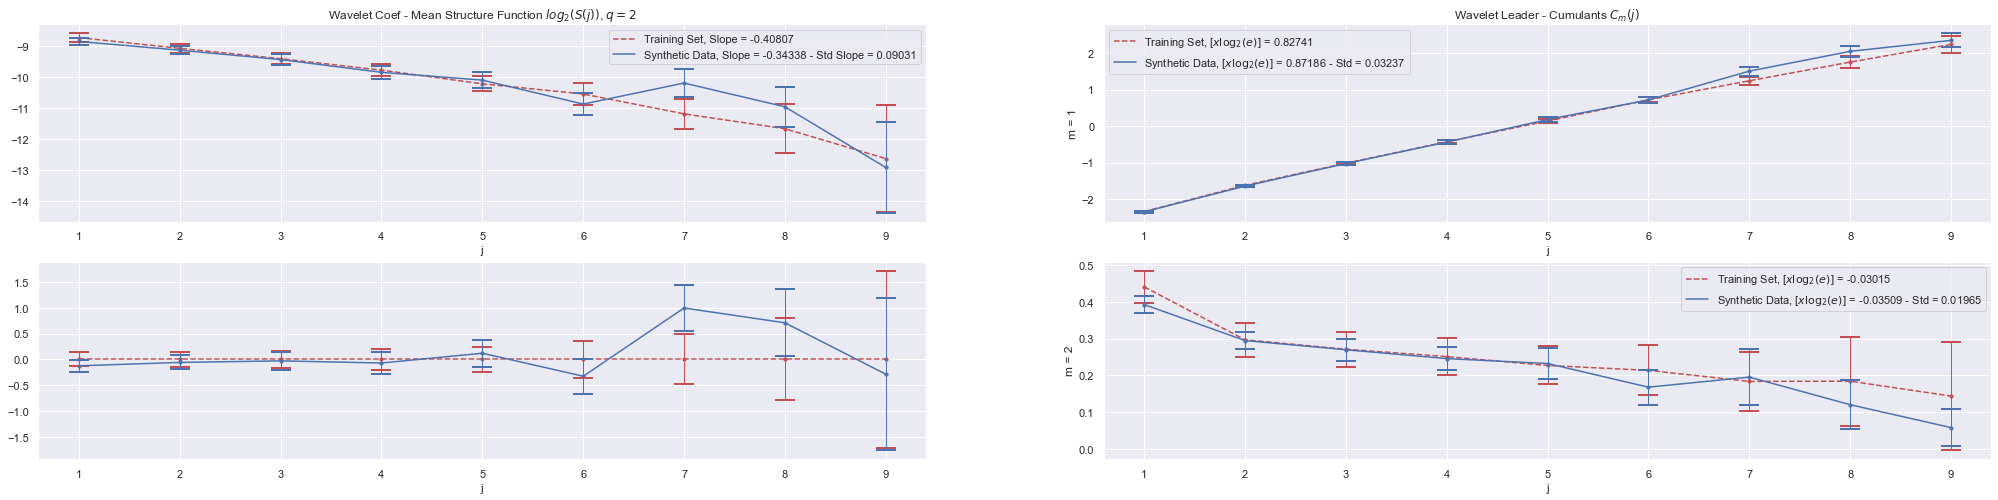

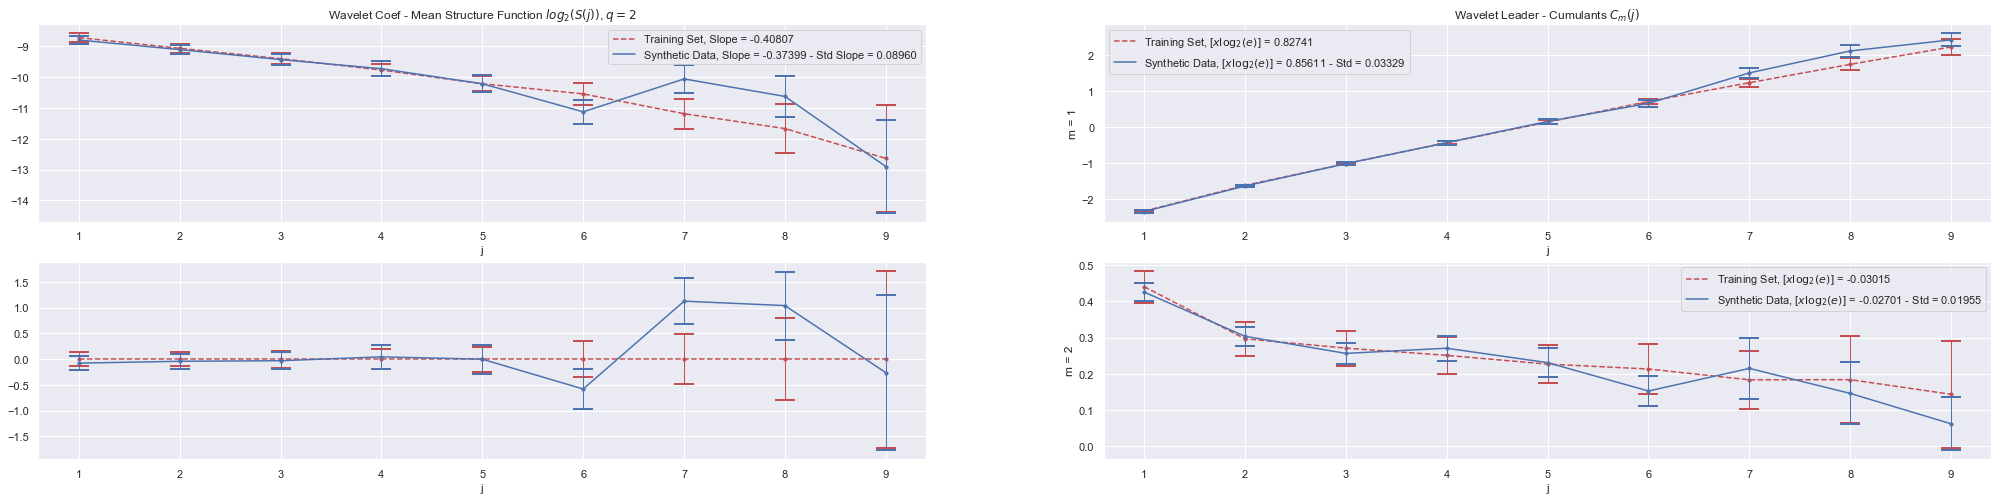

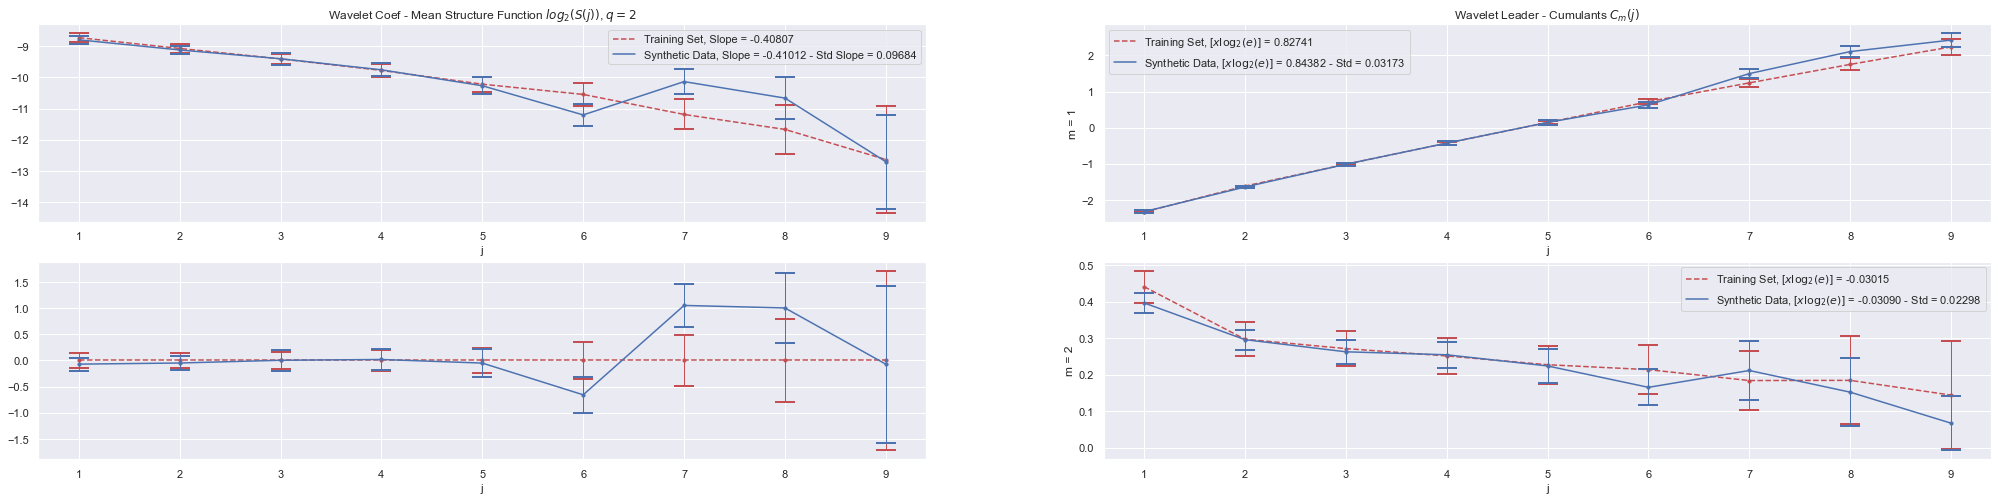

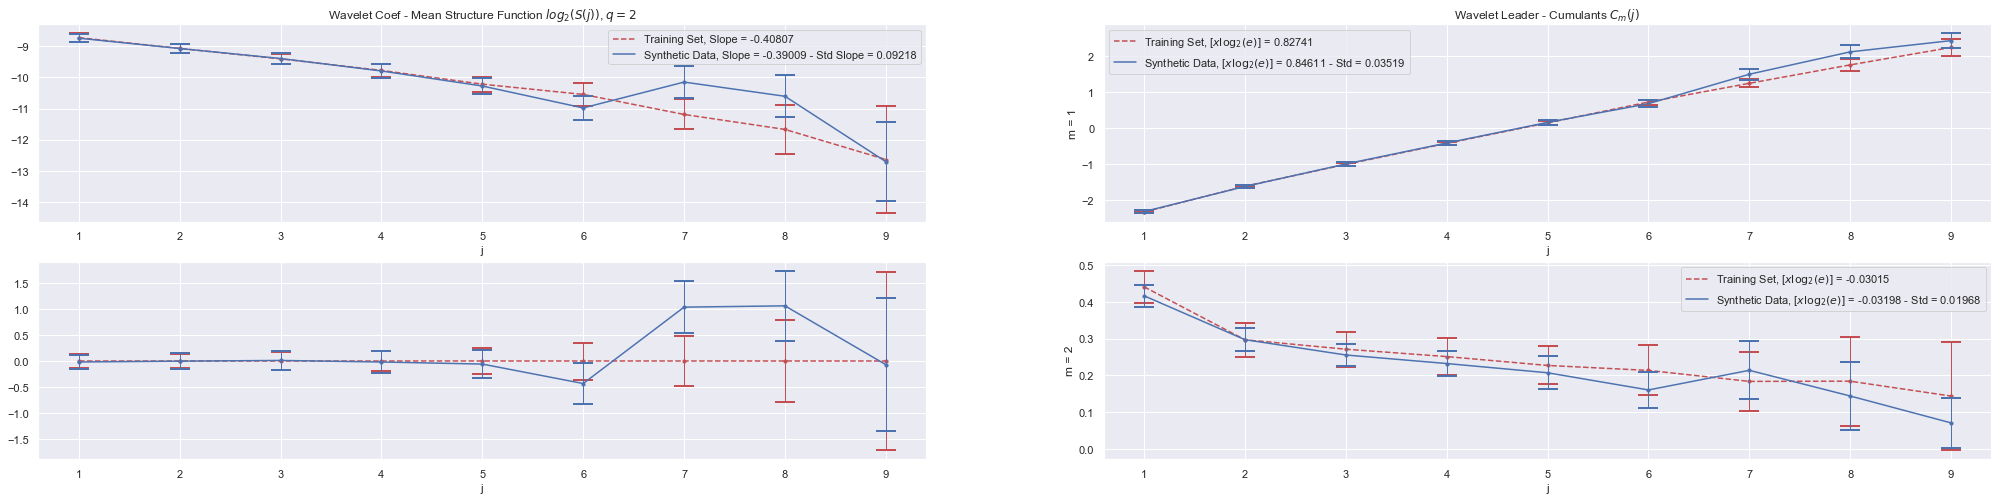

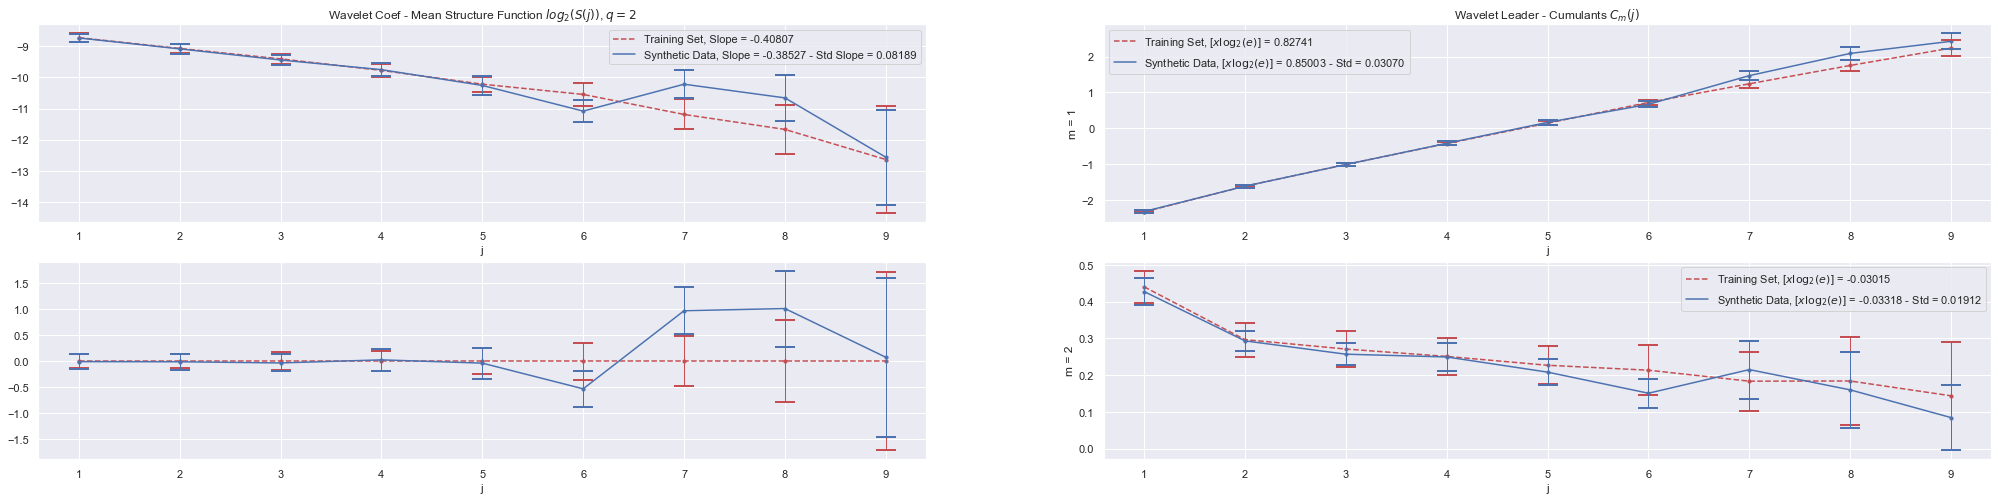

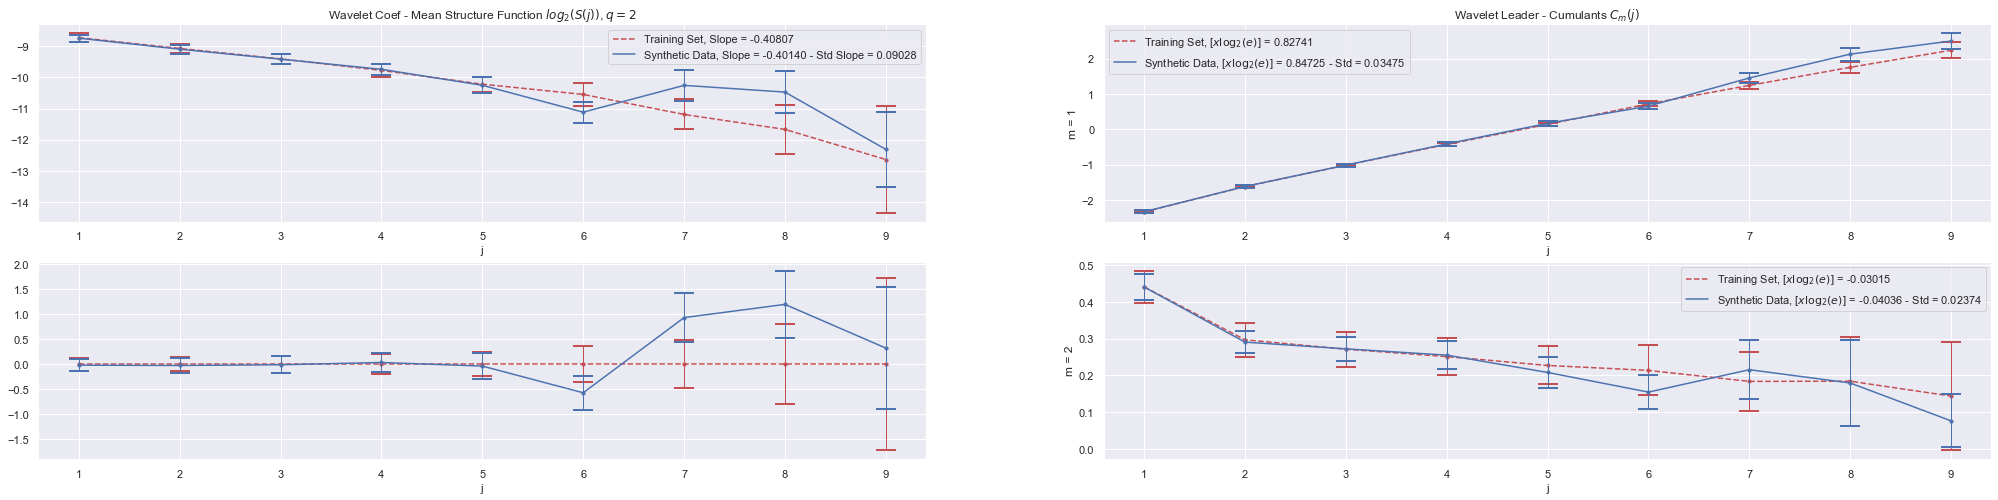

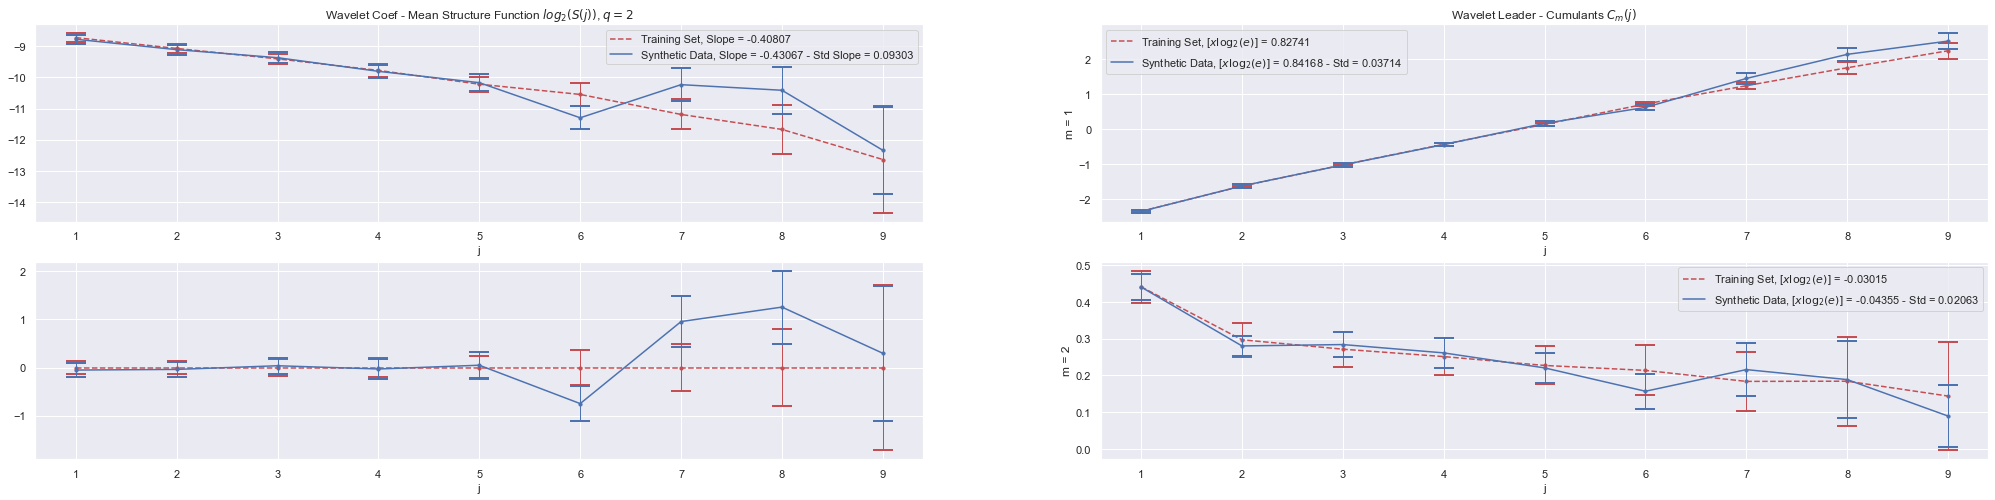

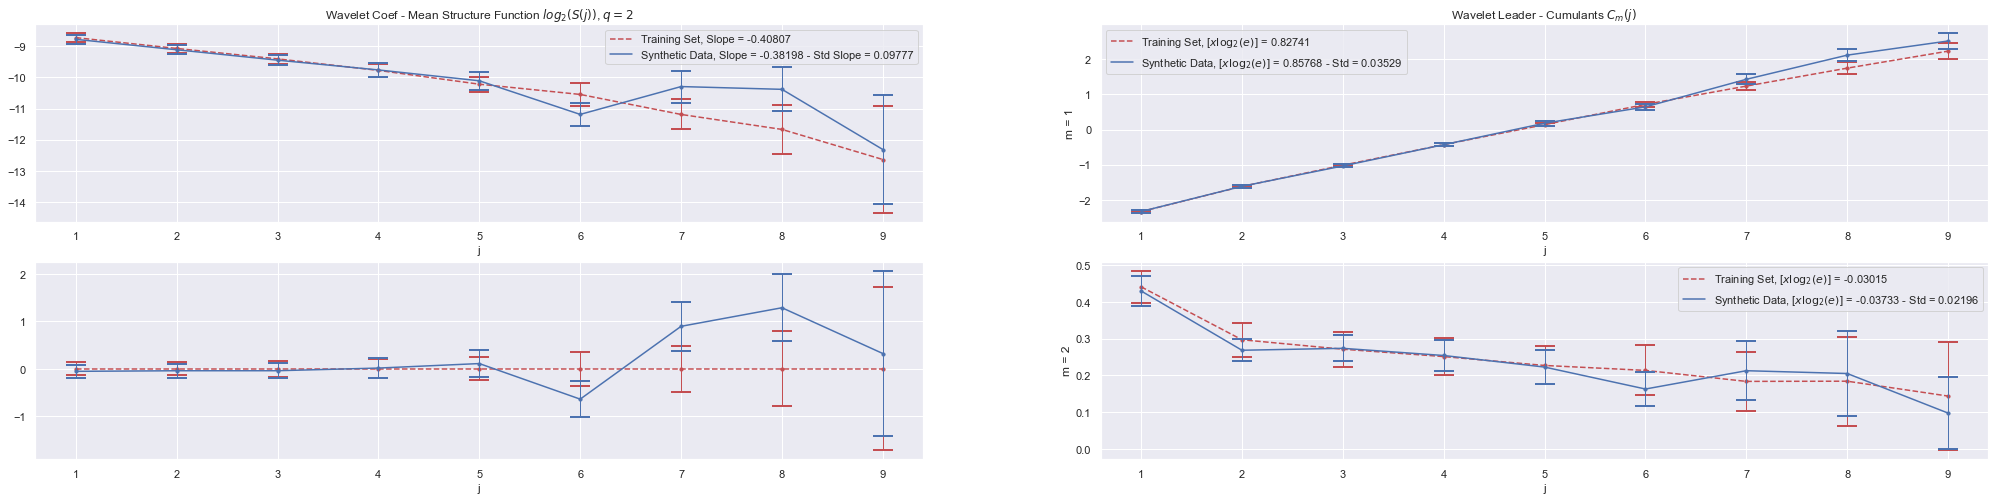

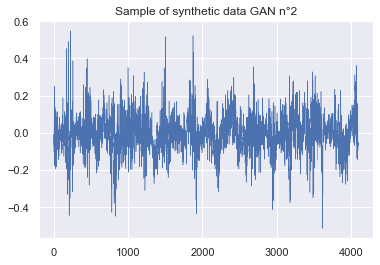

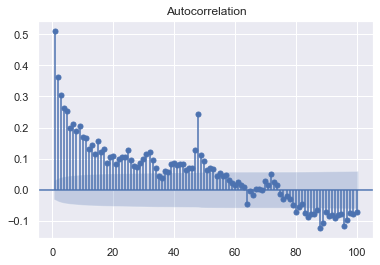

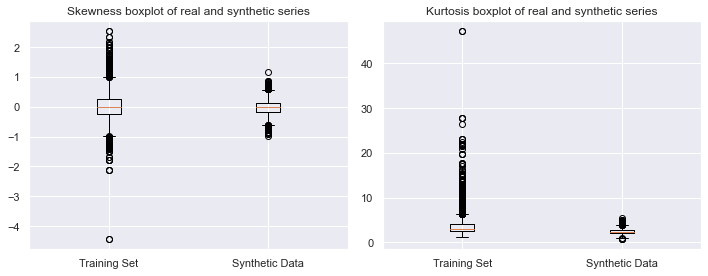

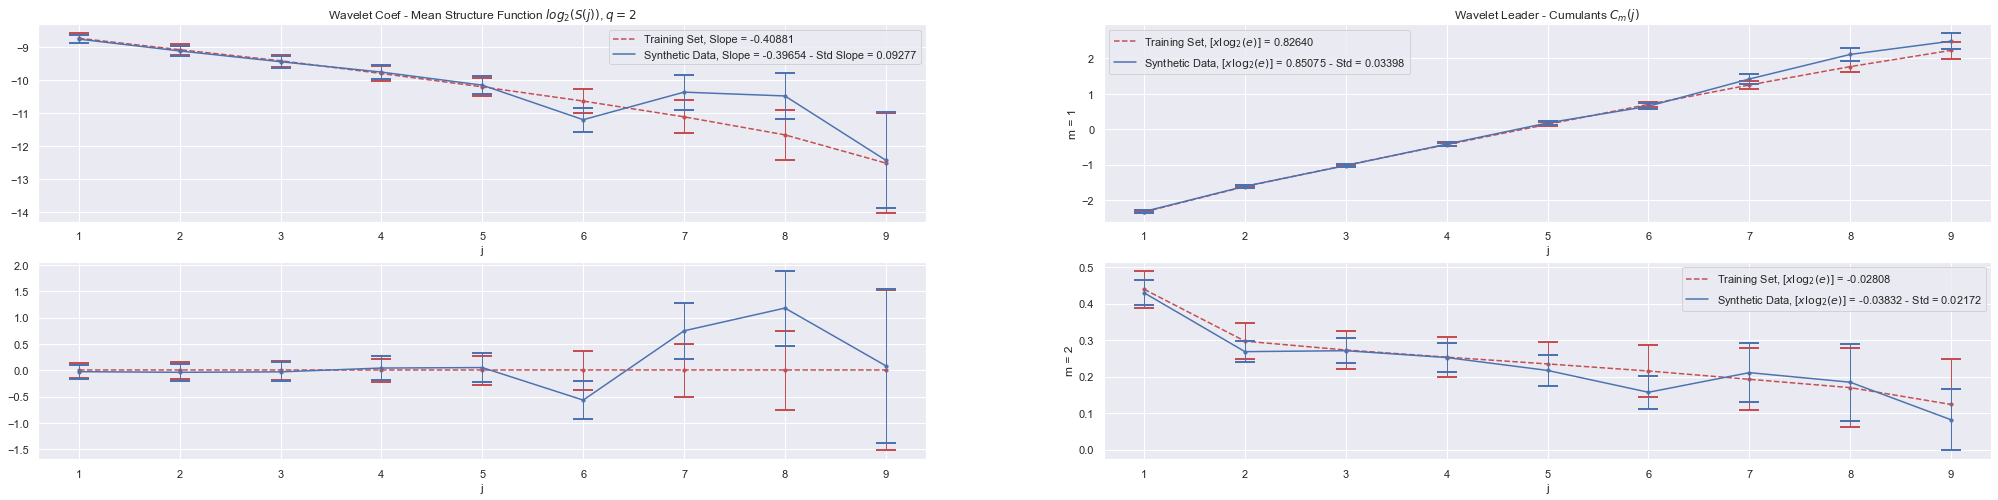

.....
New Training
.....


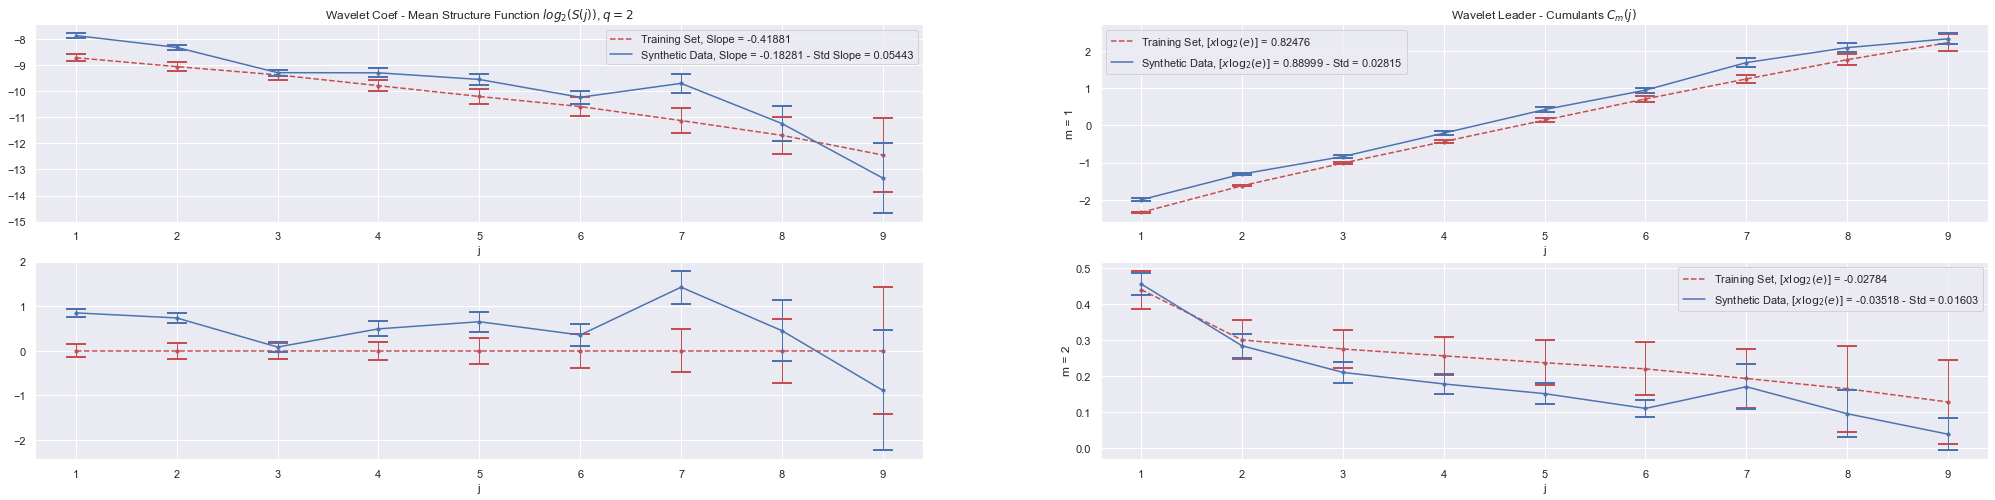

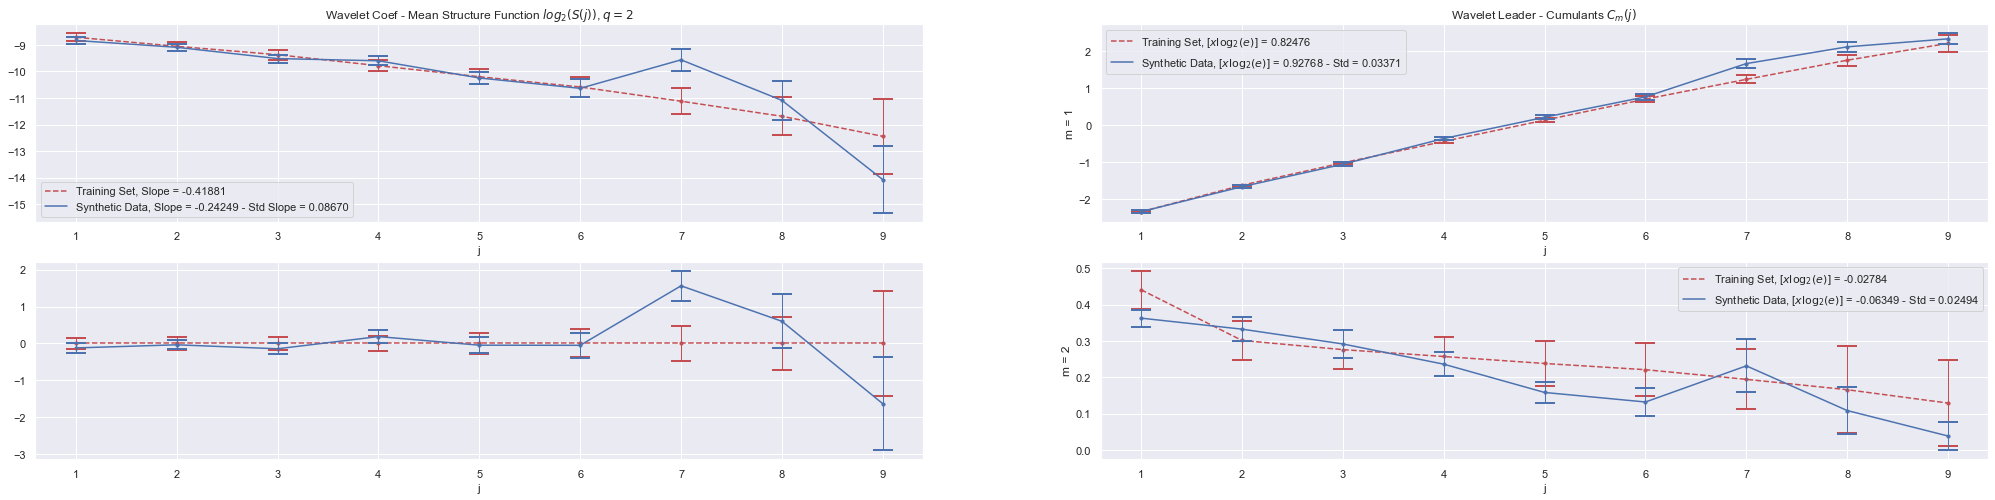

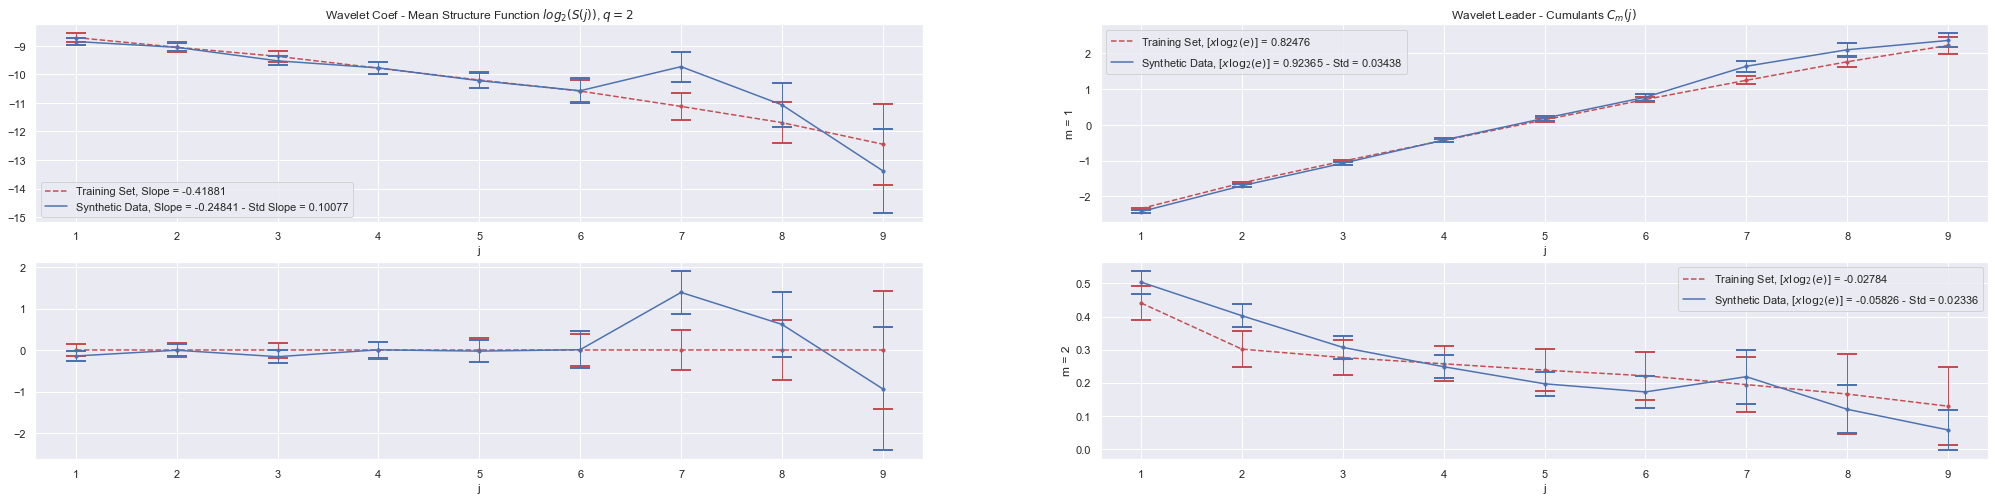

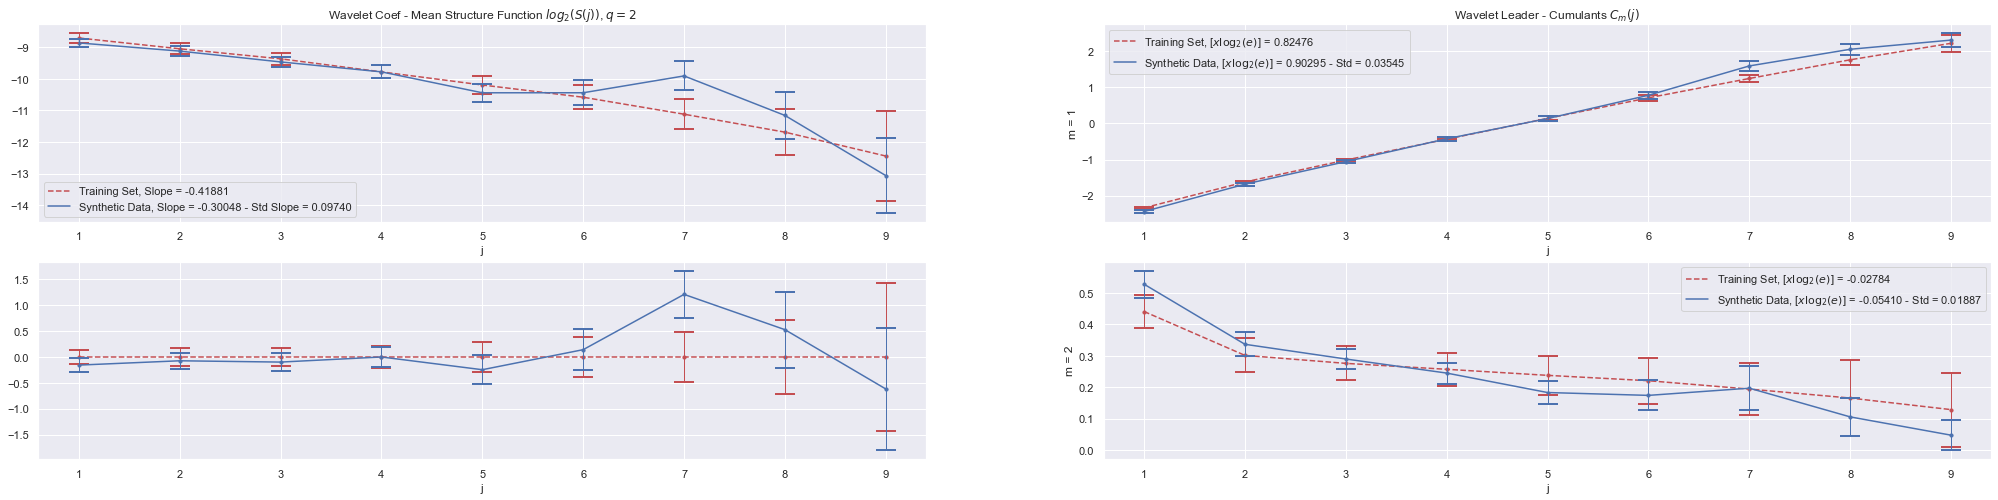

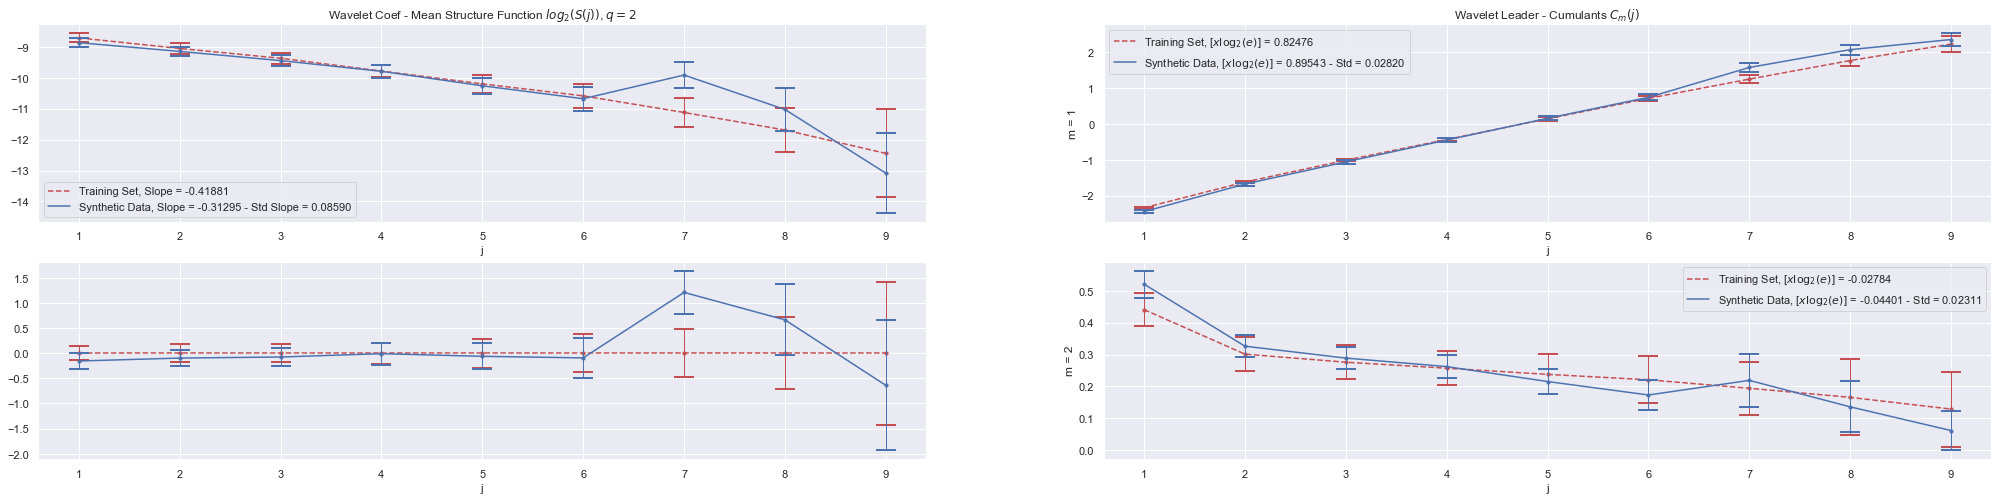

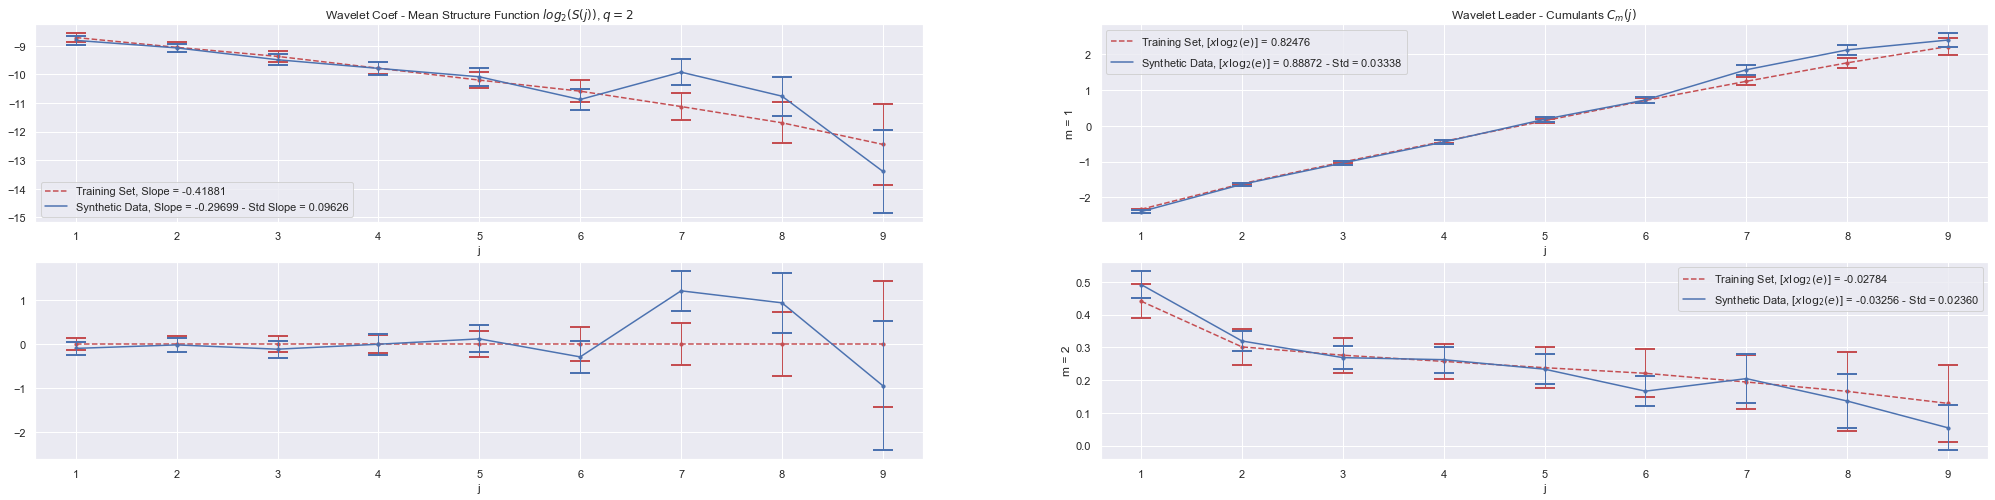

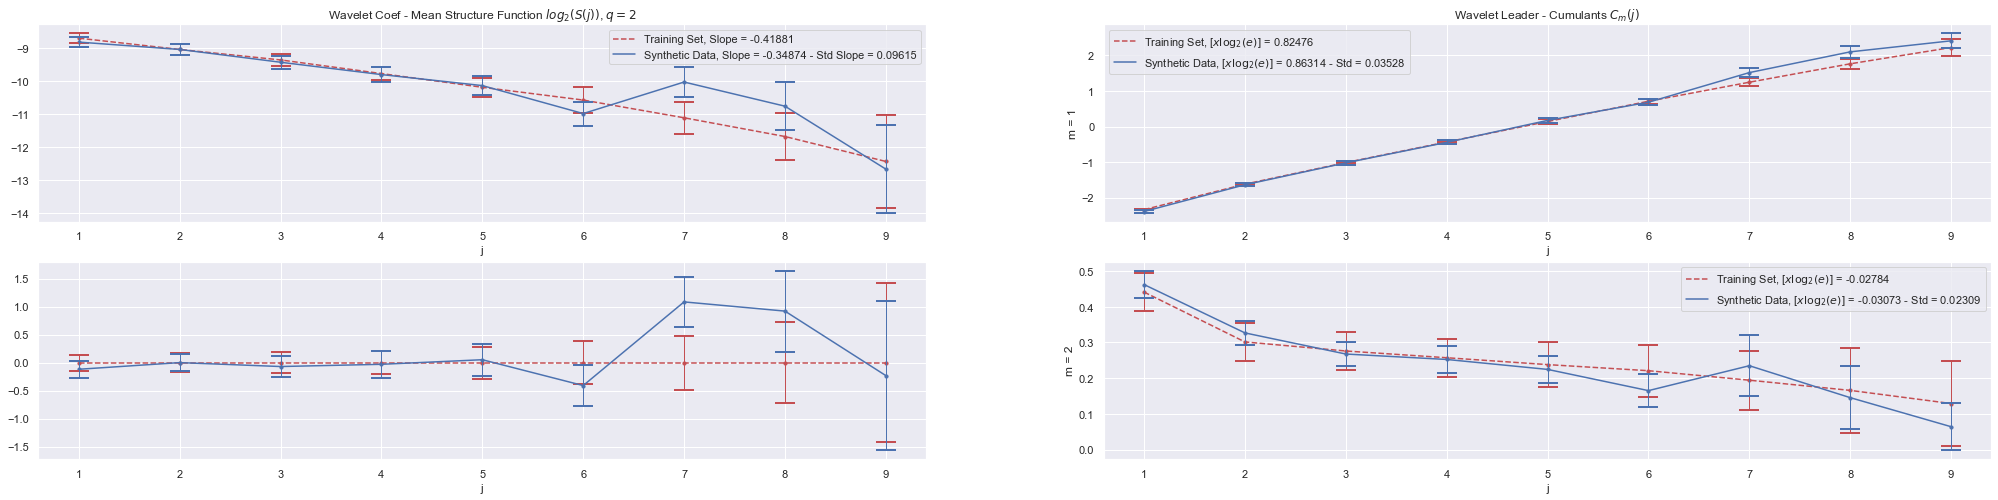

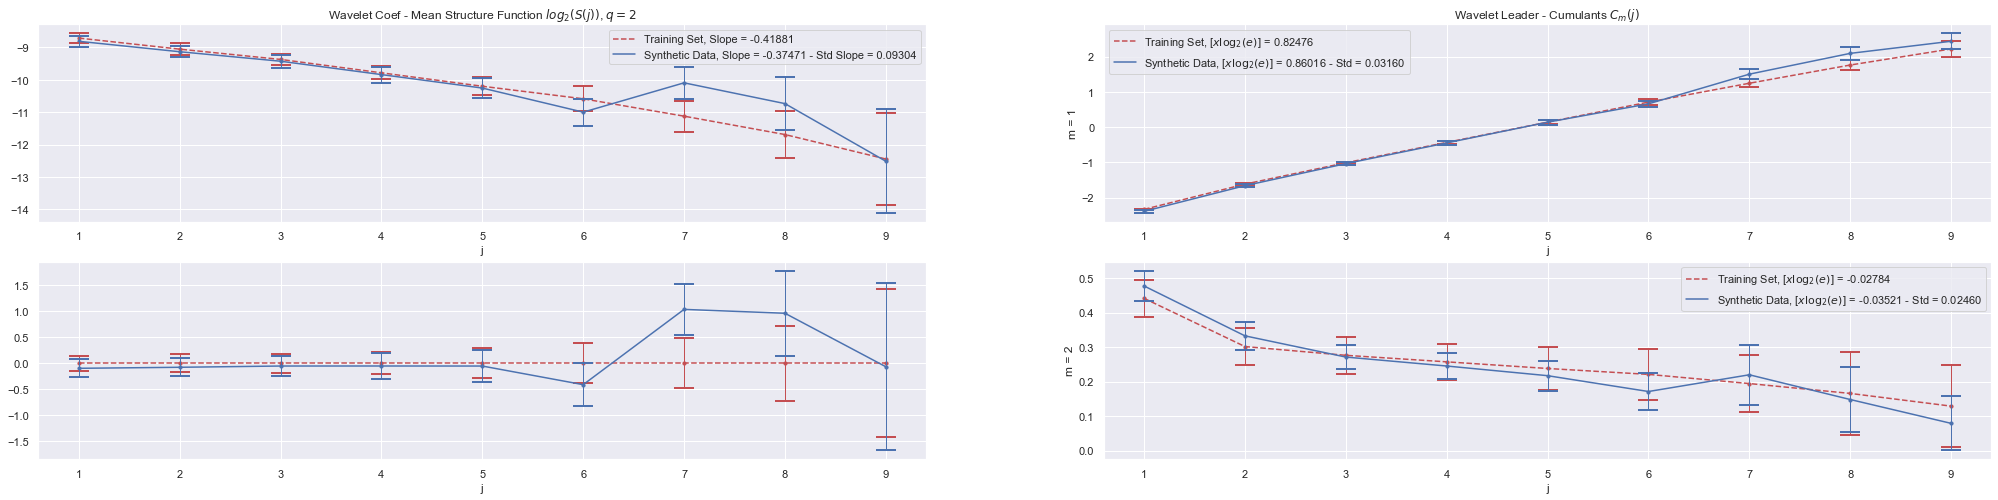

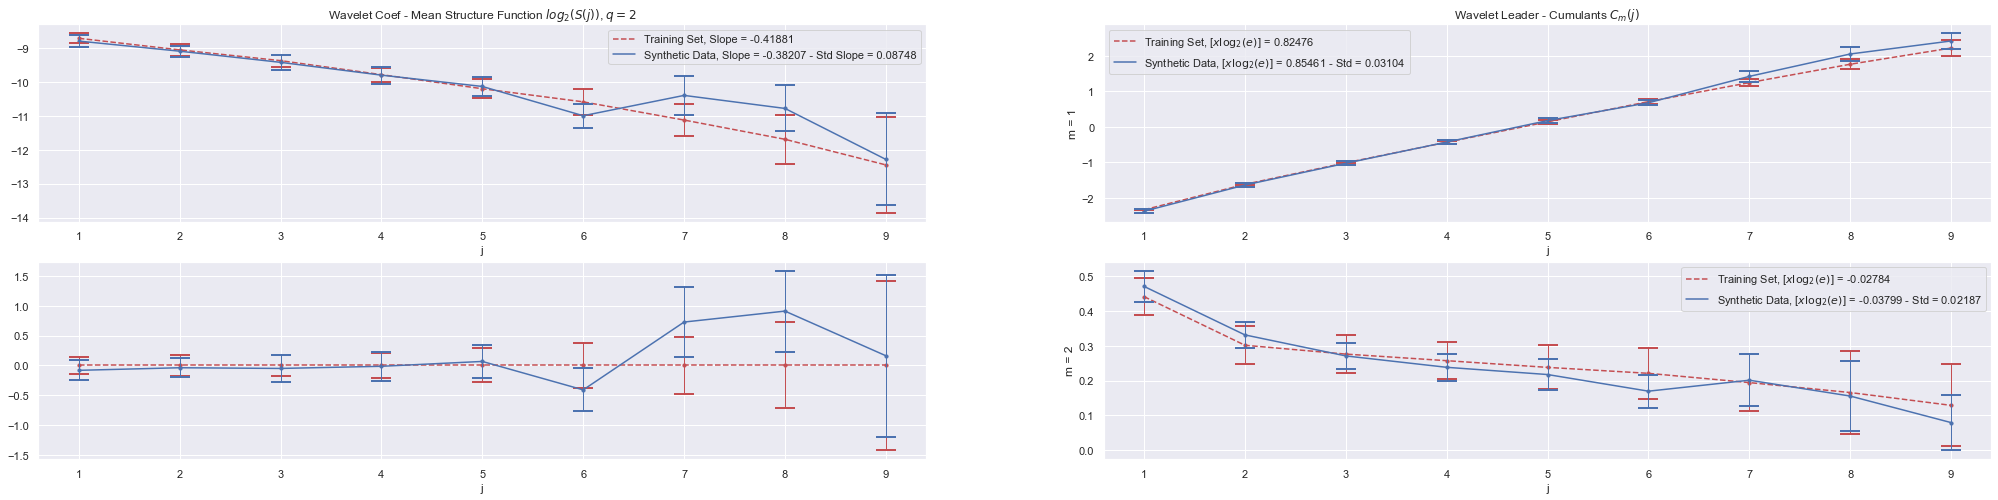

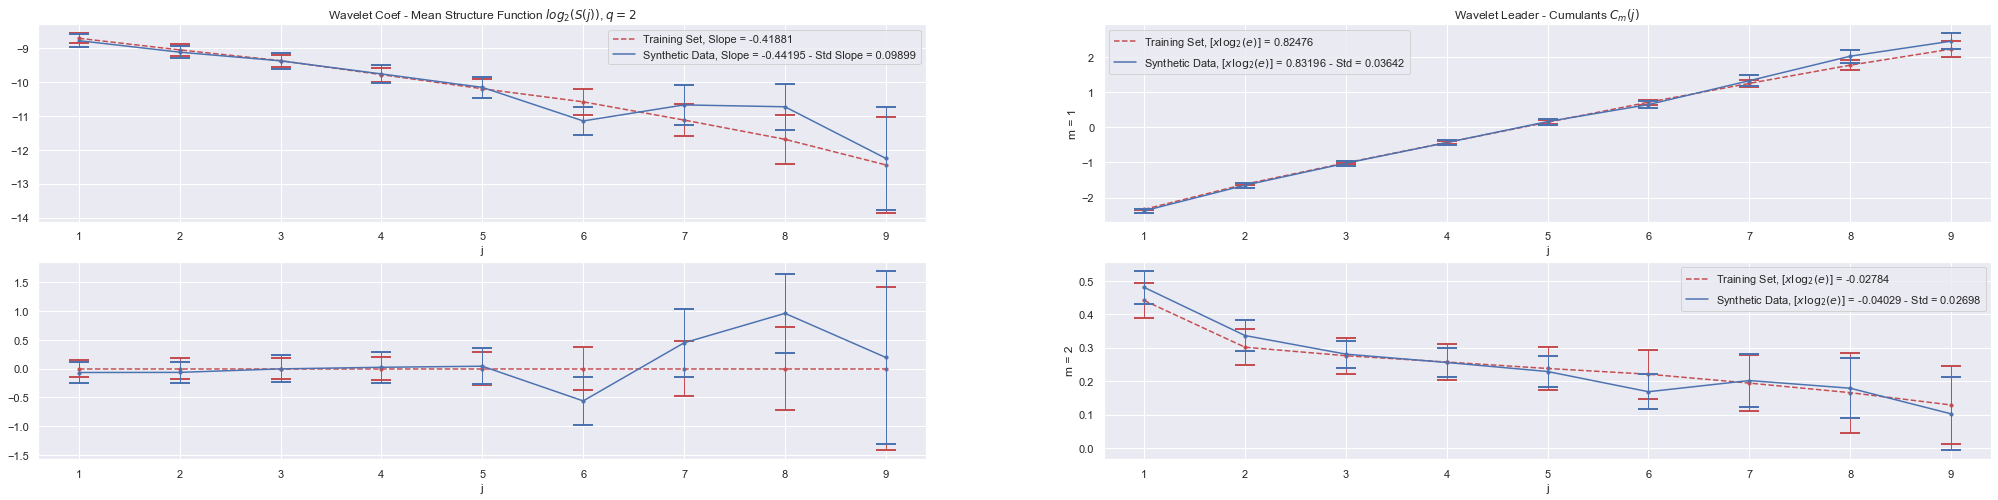

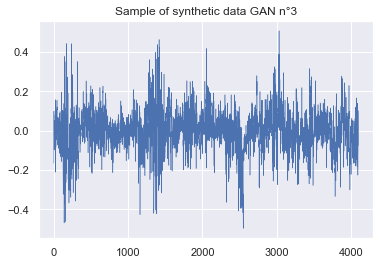

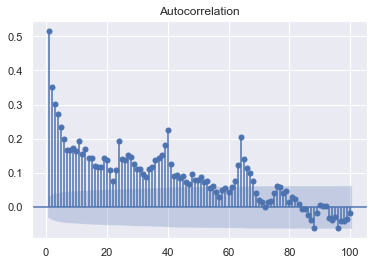

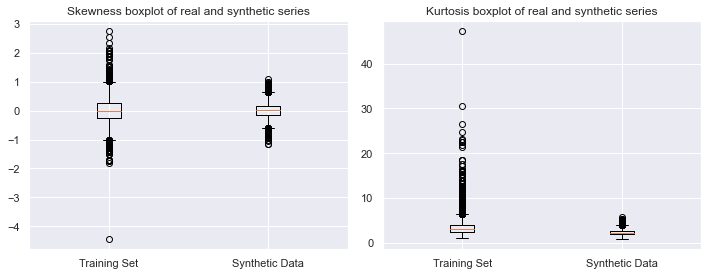

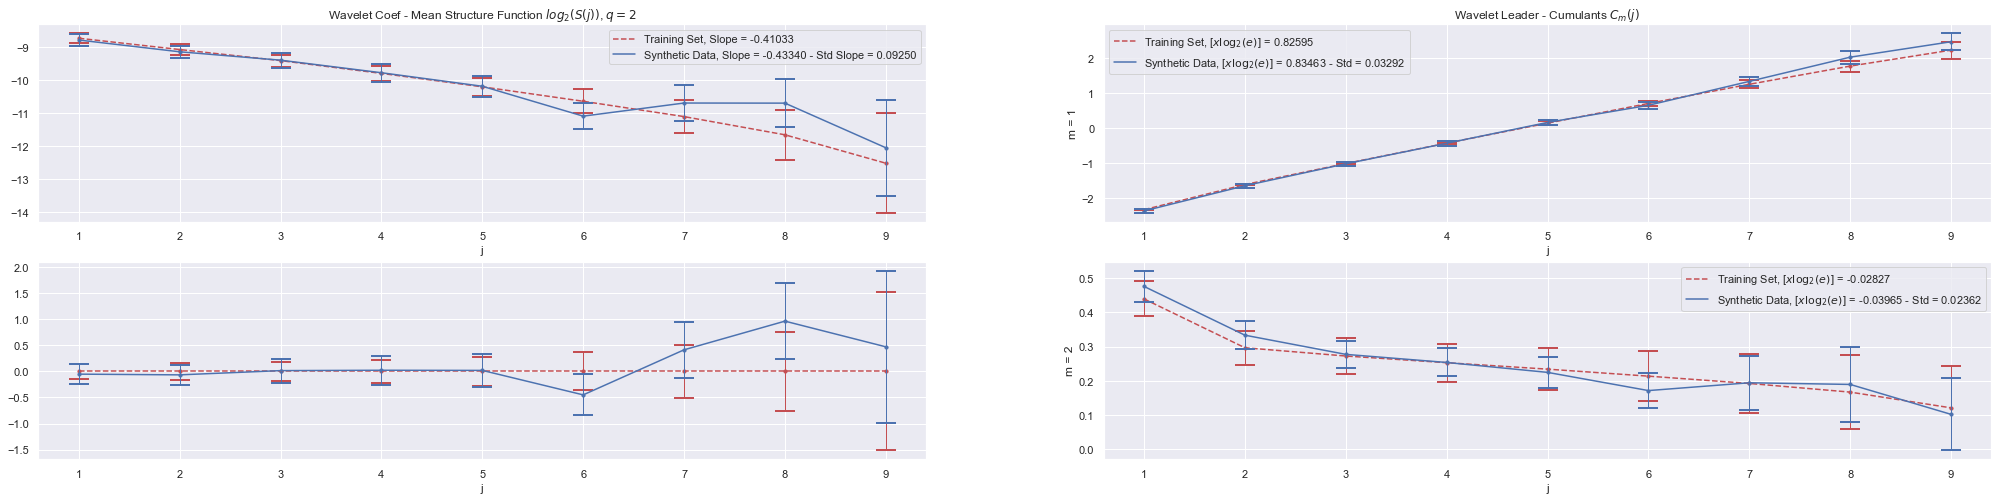

In [19]:
generators0, discriminators0, trainers0, synthetic_datas0, plot_result_sf0, plot_result_m0 = complet_training(n, '2022-07-18_mrw_0.8_0.03_0_0', '\\training_set_smrw_0.8_0.03_0_0.csv', latent_dim, ts_dim, epochs, device)
torch.cuda.empty_cache()

In [12]:
synthetic_datassmrw = []
for i in range (1,4):
    generator = Generator()
    generator.load_state_dict(torch.load(r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-07-27_smrw\Training n° {}\10000\generator10000 epochs.pth'.format(i)))
    
    noise = torch.normal(mean = 0, std = 0.3, size = (10000, latent_dim))
    synthetic_data = generator(noise).cpu()

C:\Users\Stage\anaconda3\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


In [42]:
analyse32 = []
data_train =torch.tensor(pd.read_csv(r'data_train\training_set_smrw_0.8_0.03_0.1_0.8.csv').to_numpy().astype('float32')).to(device) 
data_train = data_train[np.random.randint(low = 0, high = data_train.shape[0], size = 100)]
for i in range (3):
    analyse = Analysis_sf(data_train, synthetic_datasskew[i],  r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32.append(analyse)

C:\Users\Stage\anaconda3\lib\site-packages\pymultifracs\estimation.py:45: UserWarning: h_min = [0.] < 0. gamint should be increased
  warnings.warn(f"h_min = {hmin} < 0. gamint should be increased")


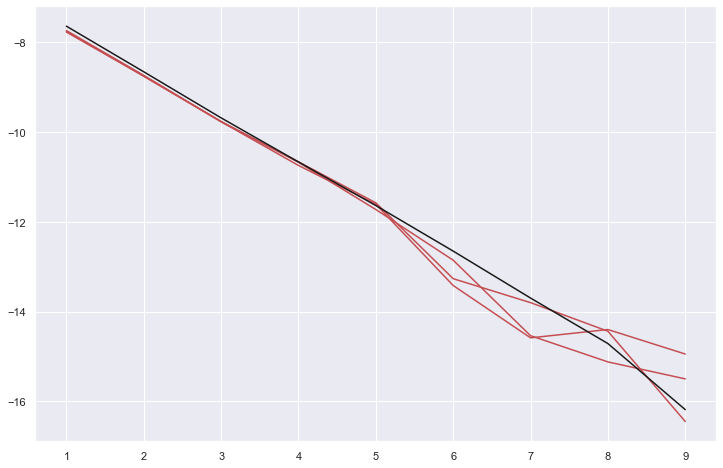

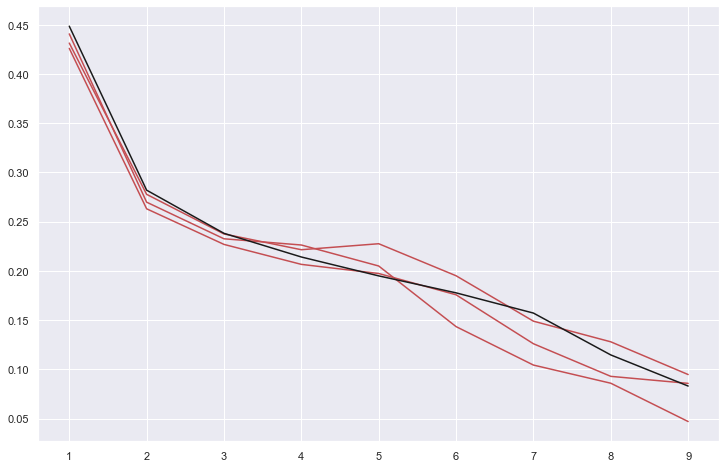

In [43]:
plt.figure(1, figsize = (6.1*2, 4*2))
for i in range (3):
    plt.plot(analyse32[i].j, analyse32[i].wavelet_result_synthetic[0], 'r')

plt.plot(analyse32[0].j, analyse32[i].wavelet_result_data[0], 'k')

plt.figure(2, figsize = (6.1*2, 4*2))
for i in range (3):
    plt.plot(analyse32[i].j, analyse32[i].cumul_result2_synthetic[0], 'r')

plt.plot(analyse32[0].j, analyse32[i].cumul_result2_data[0], 'k')


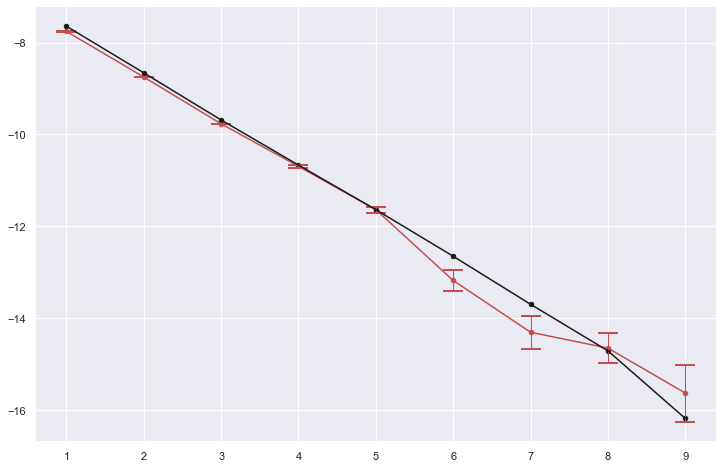

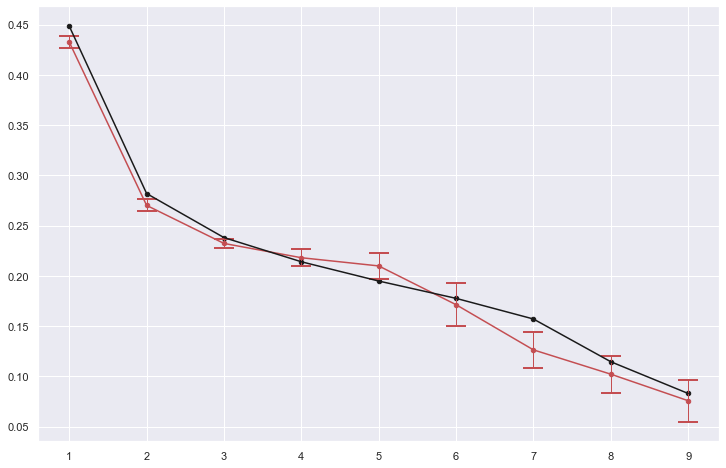

In [44]:
plt.figure(1, figsize = (6.1*2, 4*2))

plt.plot(analyse32[0].j, np.array([analyse32[i].wavelet_result_synthetic[0] for i in range (3)]).mean(axis = 0), c= 'r')
plt.scatter(analyse32[0].j, np.array([analyse32[i].wavelet_result_synthetic[0] for i in range (3)]).mean(axis = 0), c = 'r',s=20)
plt.errorbar(analyse32[0].j,\
             np.array([analyse32[i].wavelet_result_synthetic[0] for i in range (3)]).mean(axis = 0),\
             yerr = np.array([analyse32[i].wavelet_result_synthetic[0] for i in range (3)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse32[0].j, analyse32[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse32[0].j, analyse32[0].wavelet_result_data[0], c = 'k',s=20)
    
    
plt.figure(2, figsize = (6.1*2, 4*2))

plt.plot(analyse32[0].j, np.array([analyse32[i].cumul_result2_synthetic[0] for i in range (3)]).mean(axis = 0), c= 'r')
plt.scatter(analyse32[0].j, np.array([analyse32[i].cumul_result2_synthetic[0] for i in range (3)]).mean(axis = 0), c = 'r',s=20)
plt.errorbar(analyse32[0].j,\
             np.array([analyse32[i].cumul_result2_synthetic[0] for i in range (3)]).mean(axis = 0),\
             yerr = np.array([analyse32[i].cumul_result2_synthetic[0] for i in range (3)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse32[0].j, analyse32[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse32[0].j, analyse32[0].cumul_result2_data[0], c = 'k',s=20)

In [47]:
from scipy.io import savemat
sf32 = {'TS' : analyse32[0].wavelet_result_data}

for i in range (3):
    sf32['TConv512_{}'.format(i+1)] = analyse32[i].wavelet_result_synthetic

    
savemat('dataFigureSFsmrw32.mat', sf32)
np.save('dataFigureSFsmrw32', sf32)

In [51]:
c232 = {'TS' : analyse32[0].cumul_result2_data}

for i in range (3):
    c232['TConv512_{}'.format(i+1)] = analyse32[i].cumul_result2_synthetic


savemat('dataFigureC2smrw32.mat', c232)
np.save('dataFigureC2smrw32', c232)

In [53]:
sf_mean32 = {'TS' : analyse32[0].wavelet_result_data, 
              'TConv32' : np.array([analyse32[i].wavelet_result_synthetic[0] for i in range (3)]).mean(axis = 0),
              'TConv32_std' :np.array([analyse32[i].wavelet_result_synthetic[0] for i in range (3)]).std(axis = 0)}

savemat('dataFigureSFsmrw32Mean.mat', sf_mean32)
np.save('dataFigureSFsmrw32Mean', sf_mean32)

In [54]:
c2_mean32 = {'TS' : analyse32[0].cumul_result2_data, 
              'TConv32' : np.array([analyse32[i].cumul_result2_synthetic[0] for i in range (3)]).mean(axis = 0),
              'TConv32_std' :np.array([analyse32[i].cumul_result2_synthetic[0] for i in range (3)]).std(axis = 0)}

savemat('dataFigureC2smrw32Mean.mat', c2_mean32)
np.save('dataFigureC2smrw32Mean', c2_mean32)